# DUSP1 Analysis and Visualization Notebook

This notebook demonstrates how to use the new analysis manager code from `Analysis_DUSP1.py`.

In this notebook, we will:
1. Load the processed CSV files (spots, clusters, and cell properties).
2. Instantiate the measurement manager (DUSP1Measurement) and compute cell-level metrics,
   with optional SNR filtering.
3. Create a DisplayManager instance to visualize gating overlays and cell crops.
4. (Optional) Use the new expression grouping and visualization functions.

Make sure that `Analysis_DUSP1.py` is in the same directory or on the Python path.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
import os
import sys
import logging
import seaborn as sns

logging.getLogger('matplotlib.font_manager').disabled = True
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(src_path)
sys.path.append(src_path)

from src.Analysis_DUSP1_v2 import DUSP1AnalysisManager, SNRAnalysis, DUSP1Measurement, DUSP1DisplayManager

/Users/ericron/Desktop/AngelFISH


# Use the log file to search for analyses

In [2]:
loc = None
log_location = r'/Volumes/share/Users/Eric/GR_DUSP1_reruns'

In [3]:
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 

In [4]:
# list all analysis done 
all_analysis_names = am.list_analysis_names()

Analysis_DUSP1_J_NoThreshold_2025-02-22
Analysis_DUSP1_E_Feb2025_BF75thQuartile_2025-02-20
Analysis_DUSP1_L_Final_2025-03-05
Analysis_DUSP1_M_Final_2025-03-05
Analysis_DUSP1_K_Final_2025-03-05
Analysis_DUSP1_TS_R3_Final_2025-02-28
Analysis_DUSP1_E_Final_2025-03-04
Analysis_DUSP1_F_NoThreshold_2025-02-22
Analysis_DUSP1_J_Feb2025_BF75thQuartile_2025-02-21
Analysis_DUSP1_J_ERonRunAll_2025-02-06
Analysis_DUSP1_F_Feb2025_BF75thQuartile_2025-02-20
Analysis_DUSP1_I_Final_2025-03-05
Analysis_DUSP1_E_NoThreshold_2025-02-21
Analysis_DUSP1_F_ERonReRun_2025-02-08
Analysis_DUSP1_TS_R2_001_2025-02-26
Analysis_DUSP1_O_Final_2025-03-05
Analysis_DUSP1_H_Final_2025-03-05
Analysis_DUSP1_TS_R2_Final_2025-03-03
Analysis_DUSP1_F_Final_2025-03-05
Analysis_DUSP1_F_JacksRunAll_2025-02-06
Analysis_DUSP1_TS_R1_Final_2025-03-03
Analysis_DUSP1_E_ERonRunAll_2025-02-06
Analysis_DUSP1_TCS_R1_Final3_2025-03-11
Analysis_DUSP1_D_Final_2025-03-04
Analysis_DUSP1_CS_R1_Final3_2025-03-11
Analysis_DUSP1_P_Final2_2025-03-06
A

In [5]:
# Initiate the class and find analysis at log_location
# Select the specific analysis - ex. DUSP1 Dex Time-Concentration Sweep Replica 1
am.select_analysis('DUSP1_D_Final')
print('locations with this dataset:', am.location)

locations with this dataset: ['/Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_90min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_120min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_150min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220304/DUSP1_Dex_75min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_0min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_20min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_30min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_180min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_10min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220304/DUSP1_Dex_60min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220303/DUSP1_Dex_50min_20220224.h5', 

In [6]:
# Load datasets
spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")
cellresults_df = am.select_datasets("cellresults", dtype="dataframe")

print("Spots shape:", spots_df.shape)
print("Clusters shape:", clusters_df.shape)
print("Cell properties shape:", props_df.shape)
print("Cell results shape:", cellresults_df.shape)

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_90min_20220224.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_90min_20220224.h5 -> Analysis_DUSP1_D_Final_2025-03-04/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_120min_20220224.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_120min_20220224.h5 -> Analysis_DUSP1_D_Final_2025-03-04/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_150min_20220224.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_150min_20220224.h5 -> Analysis_DUSP1_D_Final_2025-03-04/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220304/DUSP1_Dex_75min_20220224.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220304/DUSP1_Dex_75min_20220224.h5 -> Analysis_DUSP1

## Step 2: Compute Cell-Level Metrics with Different SNR Filtering Methods

We create three DUSP1Measurement objects (or re-use one with different filtering options)
to compare the following methods:
- Weighted: uses weighted thresholding based on 'snr'.
- Absolute: keeps spots with snr >= 4.
- MG: computes MG_SNR and keeps spots with MG_SNR >= 'snr'.

Note: Adjust the snr_threshold for MG if needed.

In [7]:
snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=4)

In [8]:
merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

In [9]:
print('Number of spots:', merged_spots_df['unique_spot_id'].count())
print('Number of cells:', len(merged_spots_df['unique_cell_id'].unique()))
print('Numcer of cells from cell properties:', len(merged_cellprops_df['unique_cell_id'].unique()))

Number of spots: 2041174
Number of cells: 5426
Numcer of cells from cell properties: 5439


In [10]:
# Extract unique combinations from both dataframes
cellprops_combos = set(merged_cellprops_df[['NAS_location', 'cell_label', 'fov']].apply(tuple, axis=1))
spots_combos = set(merged_spots_df[['NAS_location', 'cell_label', 'fov']].apply(tuple, axis=1))

# Find combinations in cellprops but not in spots
missing_combos = cellprops_combos - spots_combos

# Display results
print(f"Number of unique cell combinations in cellprops: {len(cellprops_combos)}")
print(f"Number of unique cell combinations in spots: {len(spots_combos)}")
print(f"Number of missing combinations: {len(missing_combos)}")

# Display a few missing combinations for inspection
if missing_combos:
    print("\nSample of missing combinations (NAS_location, cell_label, fov):")
    for combo in list(missing_combos)[:5]:  # Show first 5 examples
        print(combo)
        
    # Get complete details for these missing cells
    missing_cells = merged_cellprops_df[merged_cellprops_df[['NAS_location', 'cell_label', 'fov']].apply(tuple, axis=1).isin(missing_combos)]
    print(f"\nTotal missing cells: {len(missing_cells)}")
    print("\nProperties of missing cells:")
    print(missing_cells[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']])

Number of unique cell combinations in cellprops: 5439
Number of unique cell combinations in spots: 5784
Number of missing combinations: 14

Sample of missing combinations (NAS_location, cell_label, fov):
('smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_0min_20220224/DUSP1_Dex_0min_20220224.h5', 16, 22)
('smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_90min_20220224/DUSP1_Dex_90min_20220224.h5', 13, 7)
('smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_30min_20220224/DUSP1_Dex_30min_20220224.h5', 22, 13)
('smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_90min_20220224/DUSP1_Dex_90min_20220224.h5', 15, 7)
('smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_90min_20220224/DUSP1_Dex_90min_20220224.h5', 11, 7)

Total missing cells: 14

Properties of missing cells:
                                           NAS_location  cell_label  fov  \
110   smFISH_images/Eric_smFISH_images/20220305/DUSP...          12    7   
111   smFISH_images/Eric_smFISH_images/20220305/DUSP...    

In [11]:
# import dask.array as da
# import h5py 
# import matplotlib.pyplot as plt

# def displaycell(row, channel):
#     with h5py.File('/Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_90min_20220224.h5') as f:
#         imgs = da.asarray(f['raw_images'])
#         img = imgs[row['fov'], 0, channel, 5]
#         plt.imshow(img)
#         plt.show()

# displaycell(missing_cells.iloc[0], 0)

In [12]:
merged_spots_df.to_csv('DUSP1_D_merged_spots_Mar2025.csv')

In [13]:
merged_spots_df.keys()

Index(['z_px', 'y_px', 'x_px', 'cluster_index', 'is_nuc', 'cell_label',
       'nuc_label', 'snr', 'signal', 'timepoint', 'fov', 'FISH_Channel',
       'condition', 'replica', 'time', 'Dex_Conc', 'NAS_location', 'h5_idx',
       'unique_spot_id', 'unique_cell_id', 'cell_intensity_mean-0',
       'cell_intensity_std-0', 'nuc_intensity_mean-0', 'nuc_intensity_std-0',
       'cyto_intensity_mean-0', 'cyto_intensity_std-0', 'MG_SNR', 'weighted',
       'absolute', 'snr_vs_mg', 'mg_lt_snr'],
      dtype='object')

In [14]:
merged_spots_df['weighted'].unique()

array([ True, False])

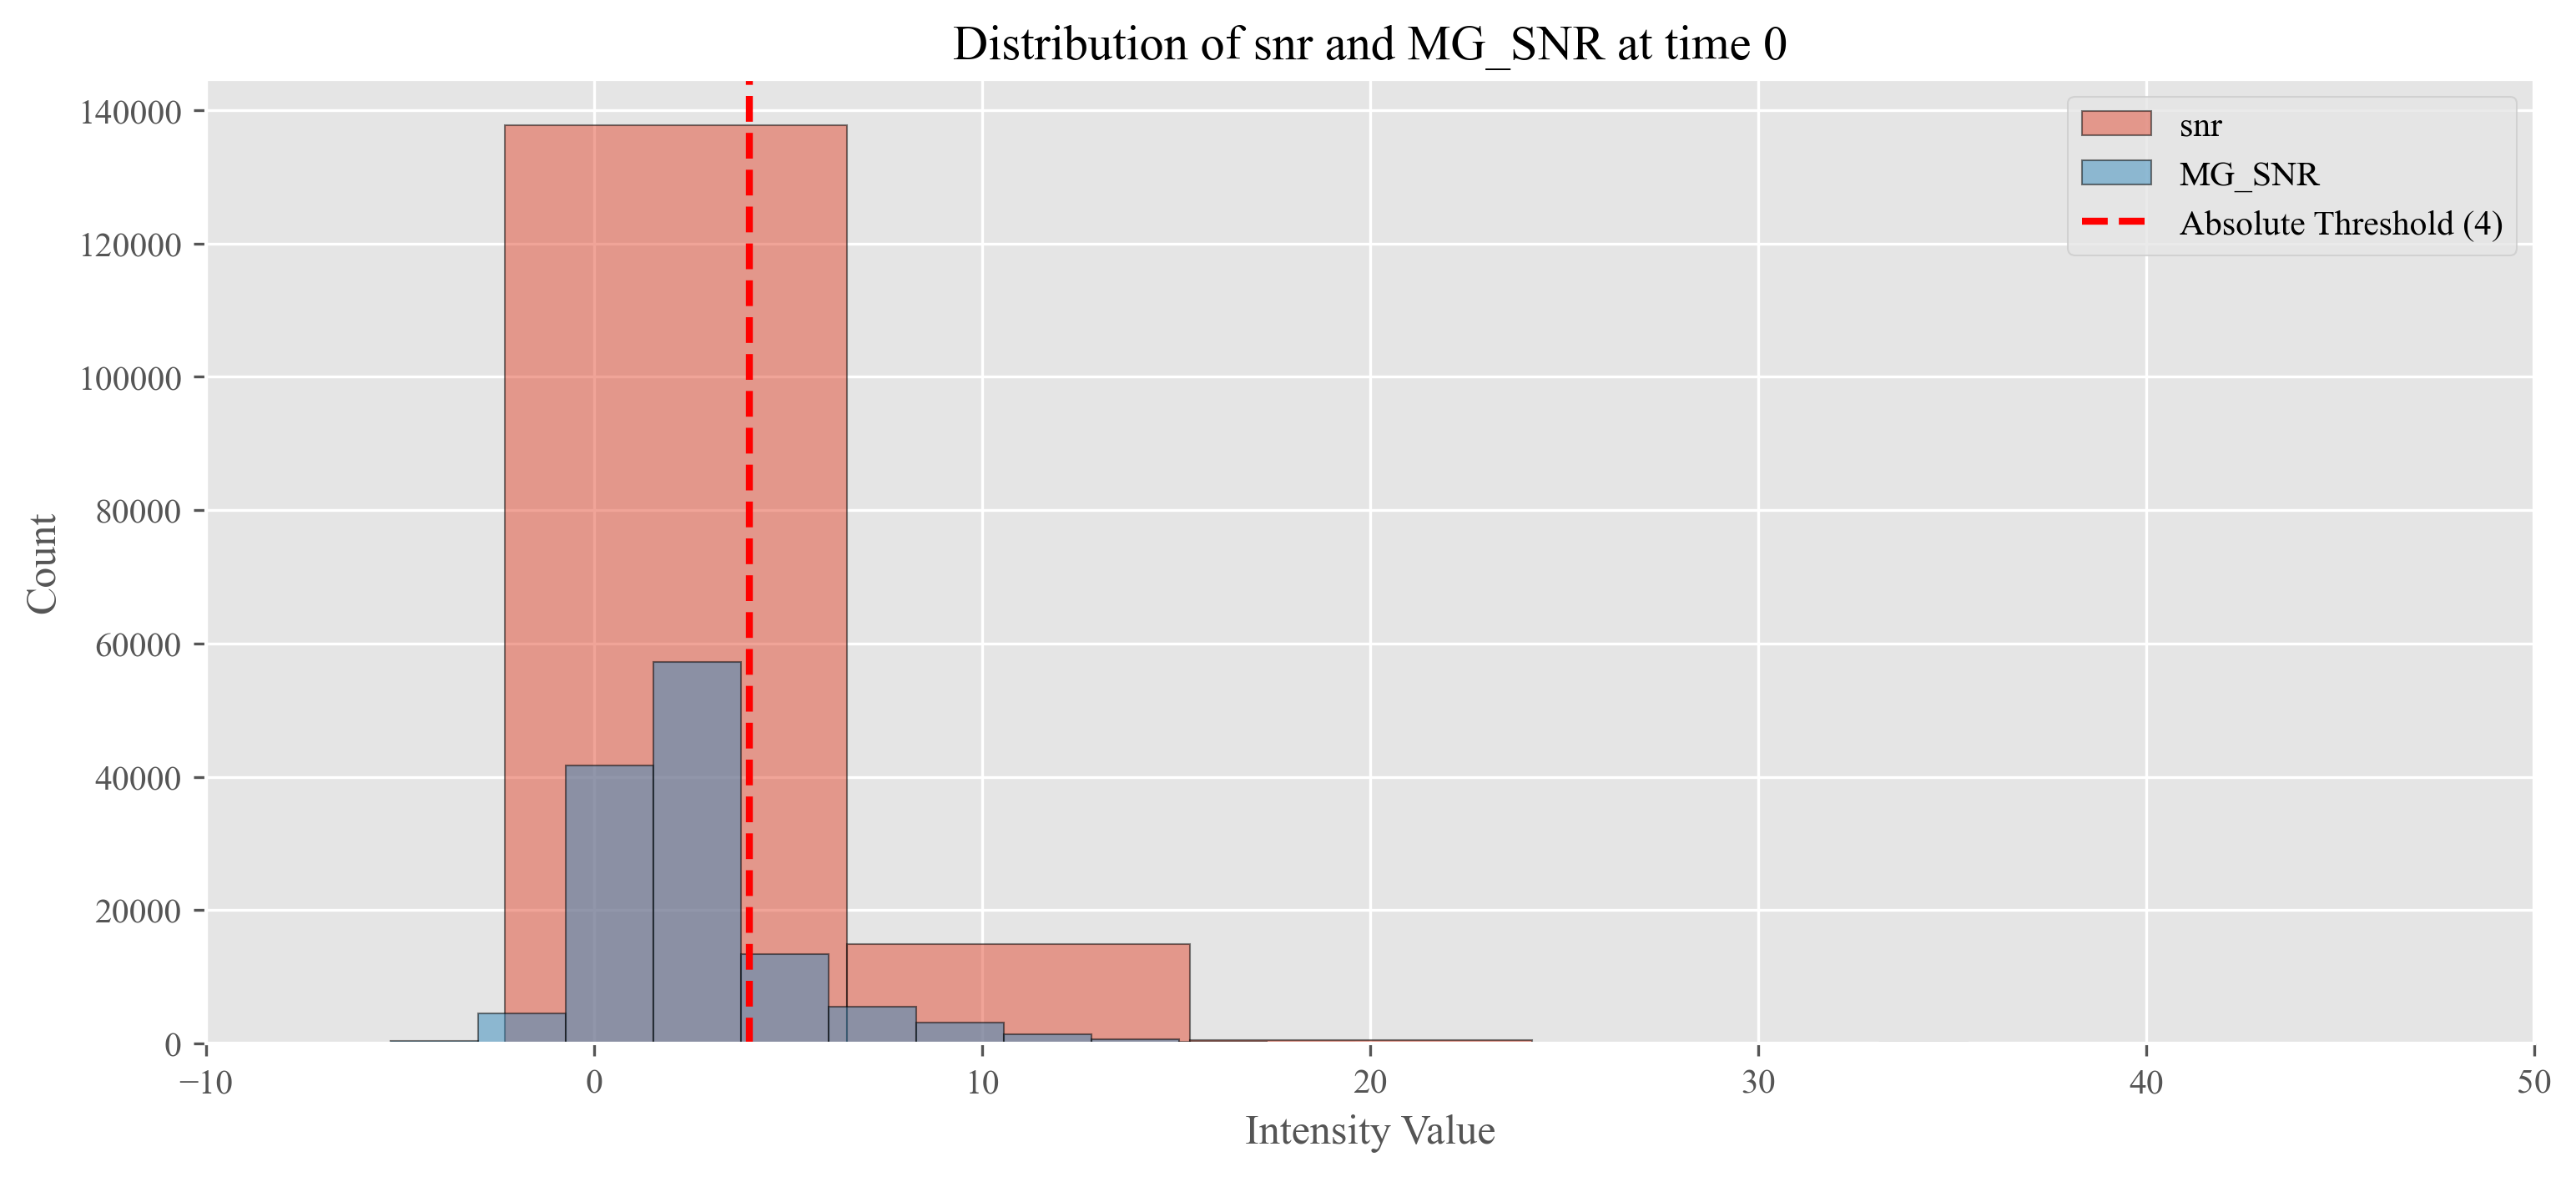

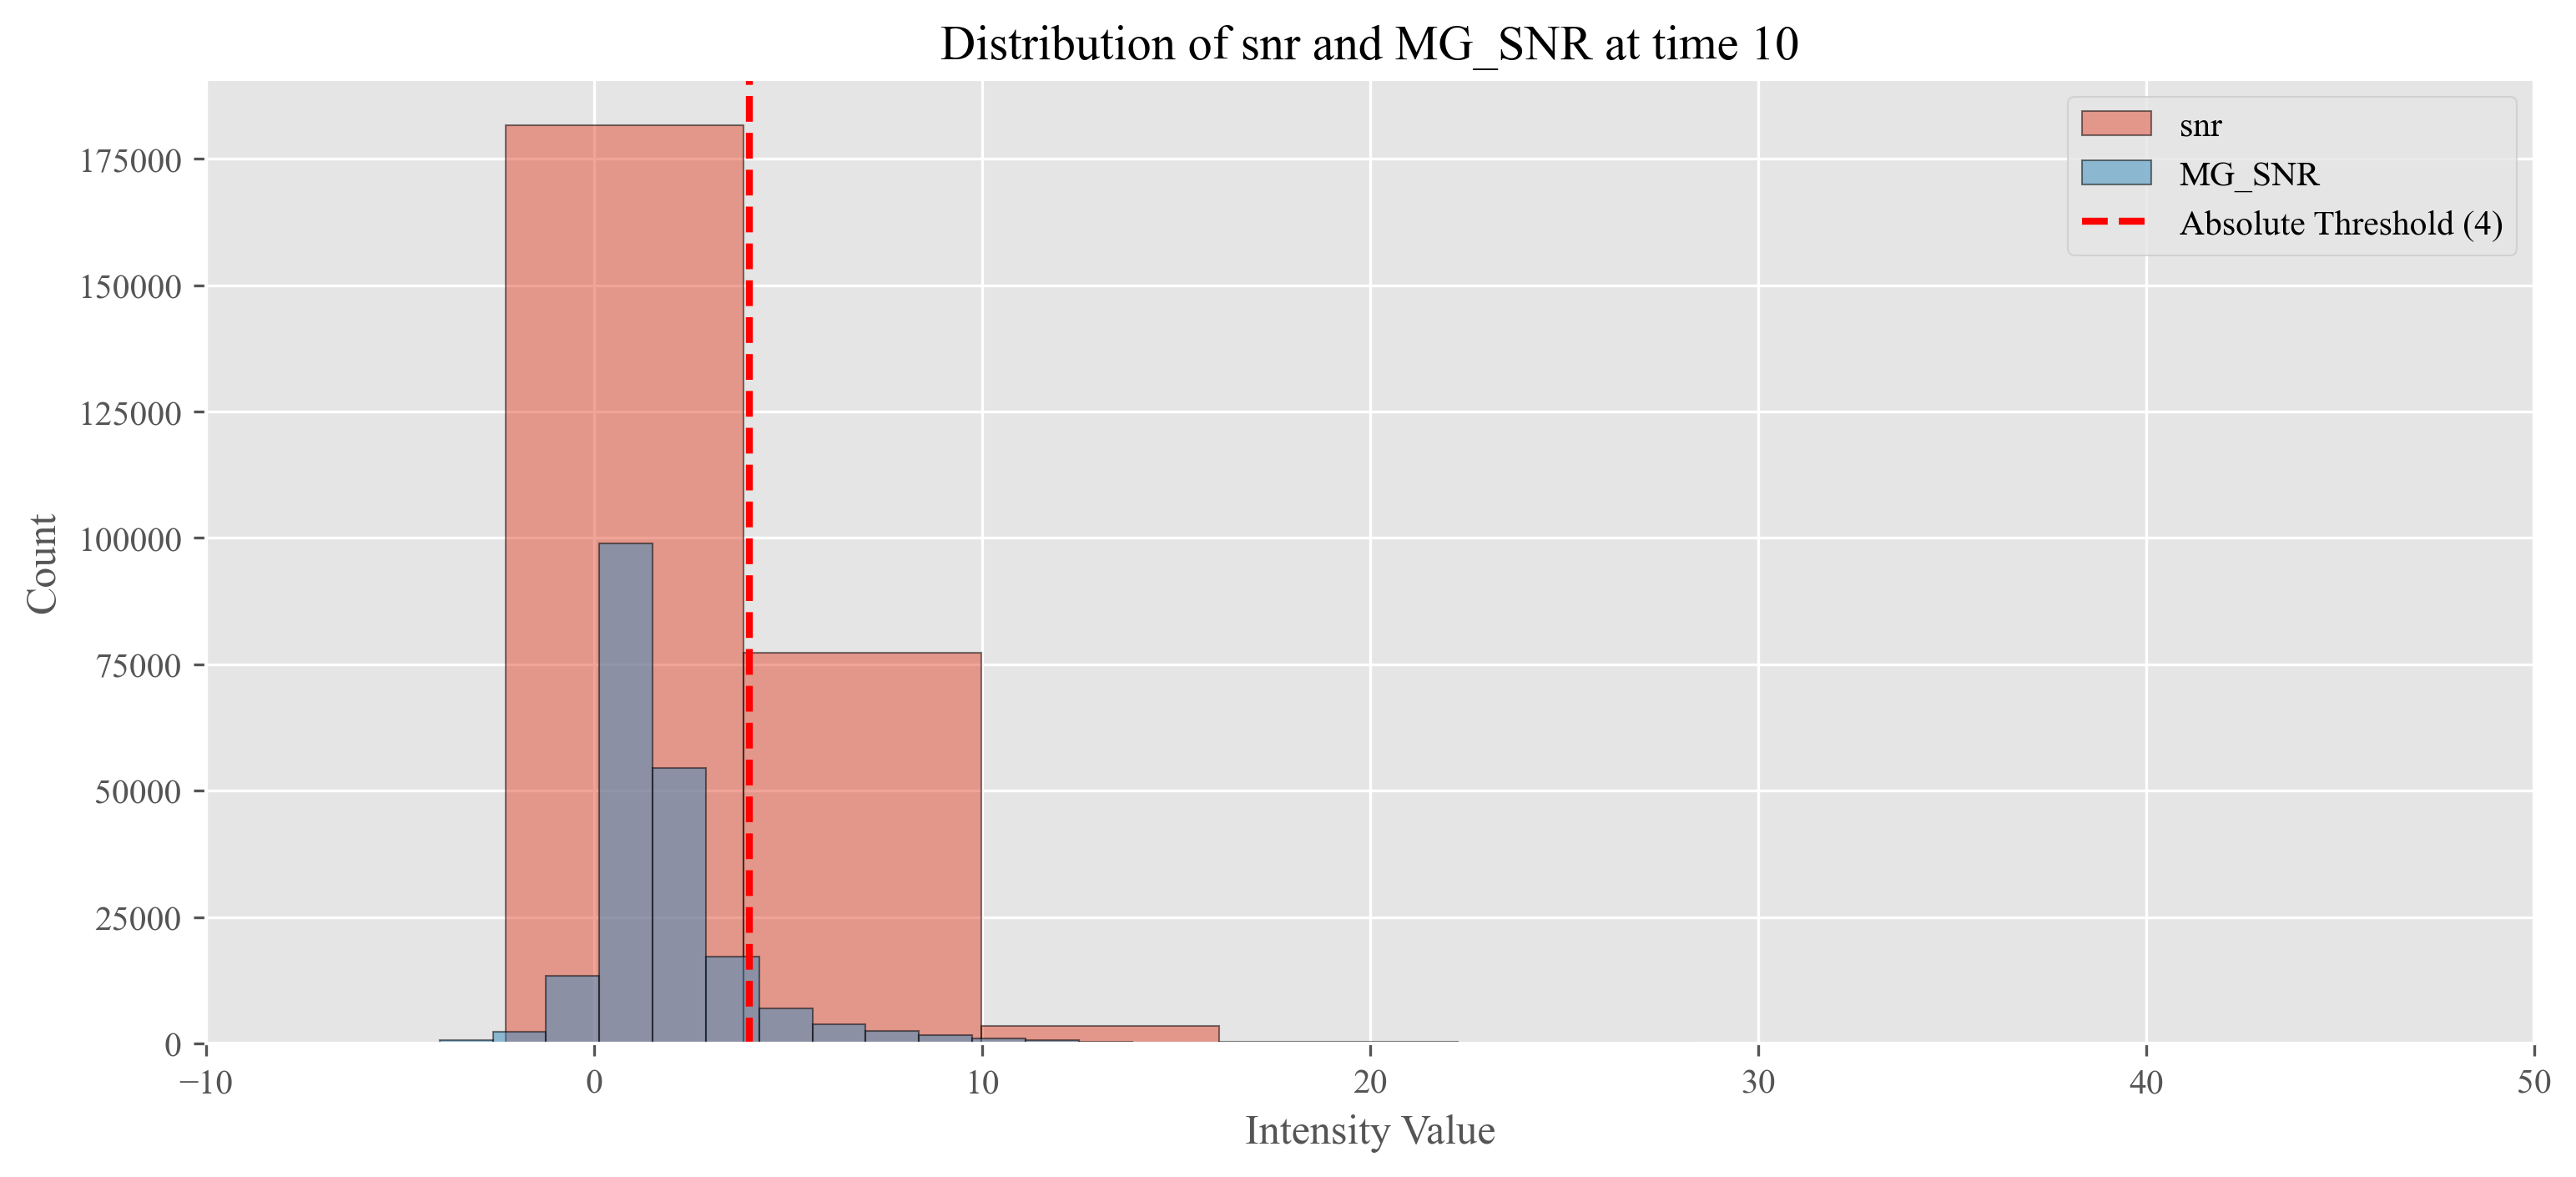

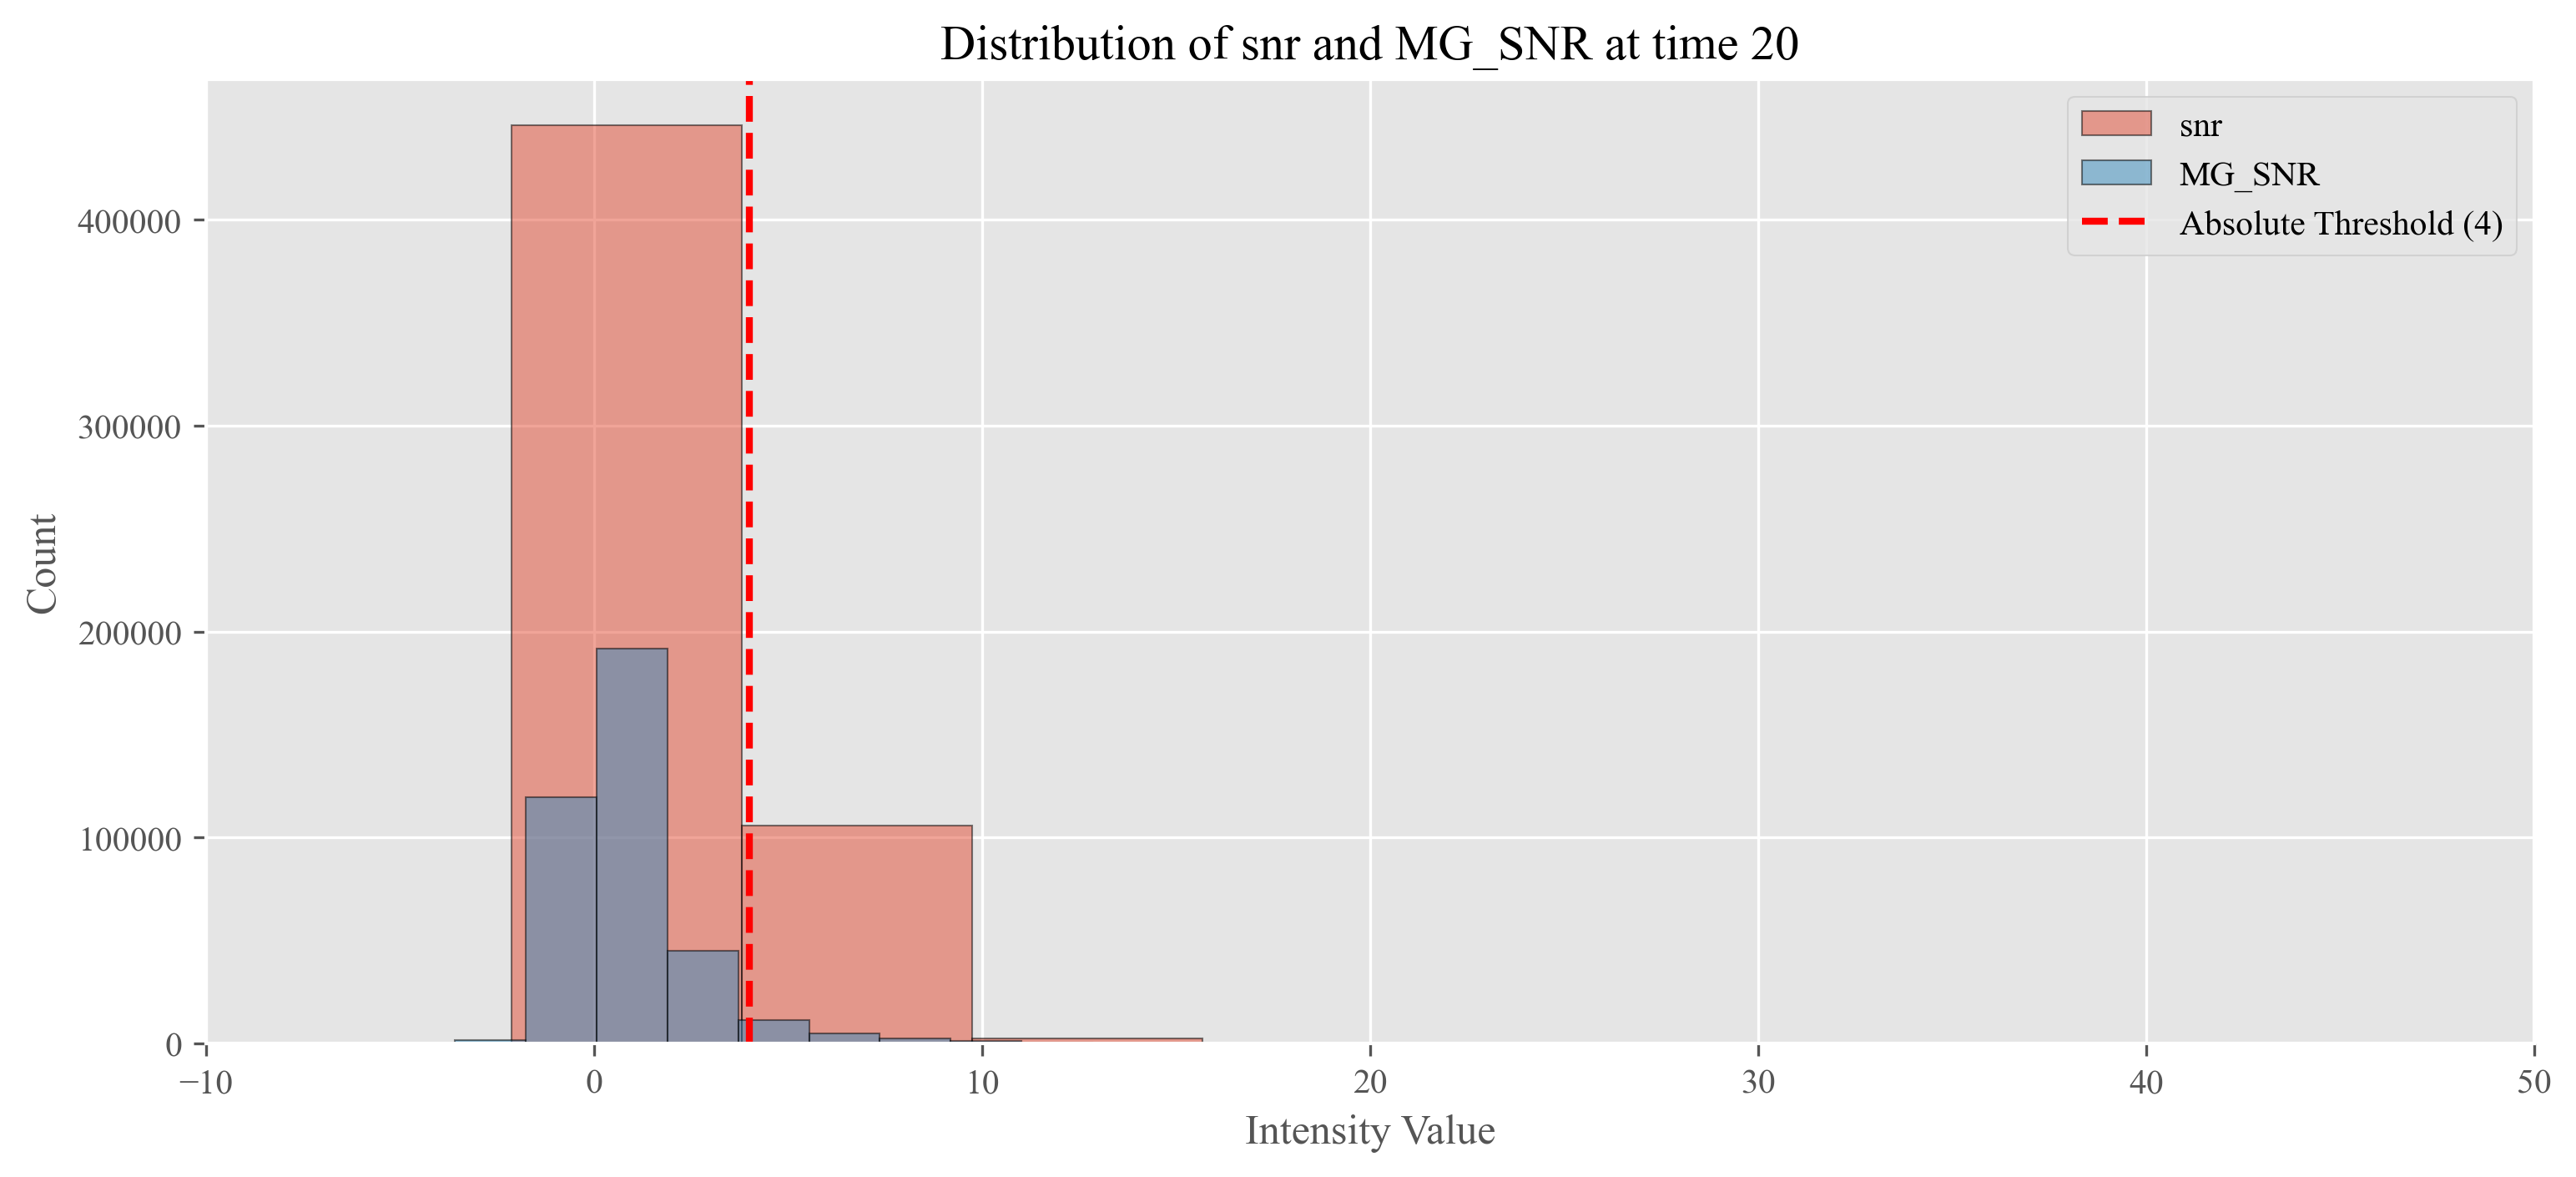

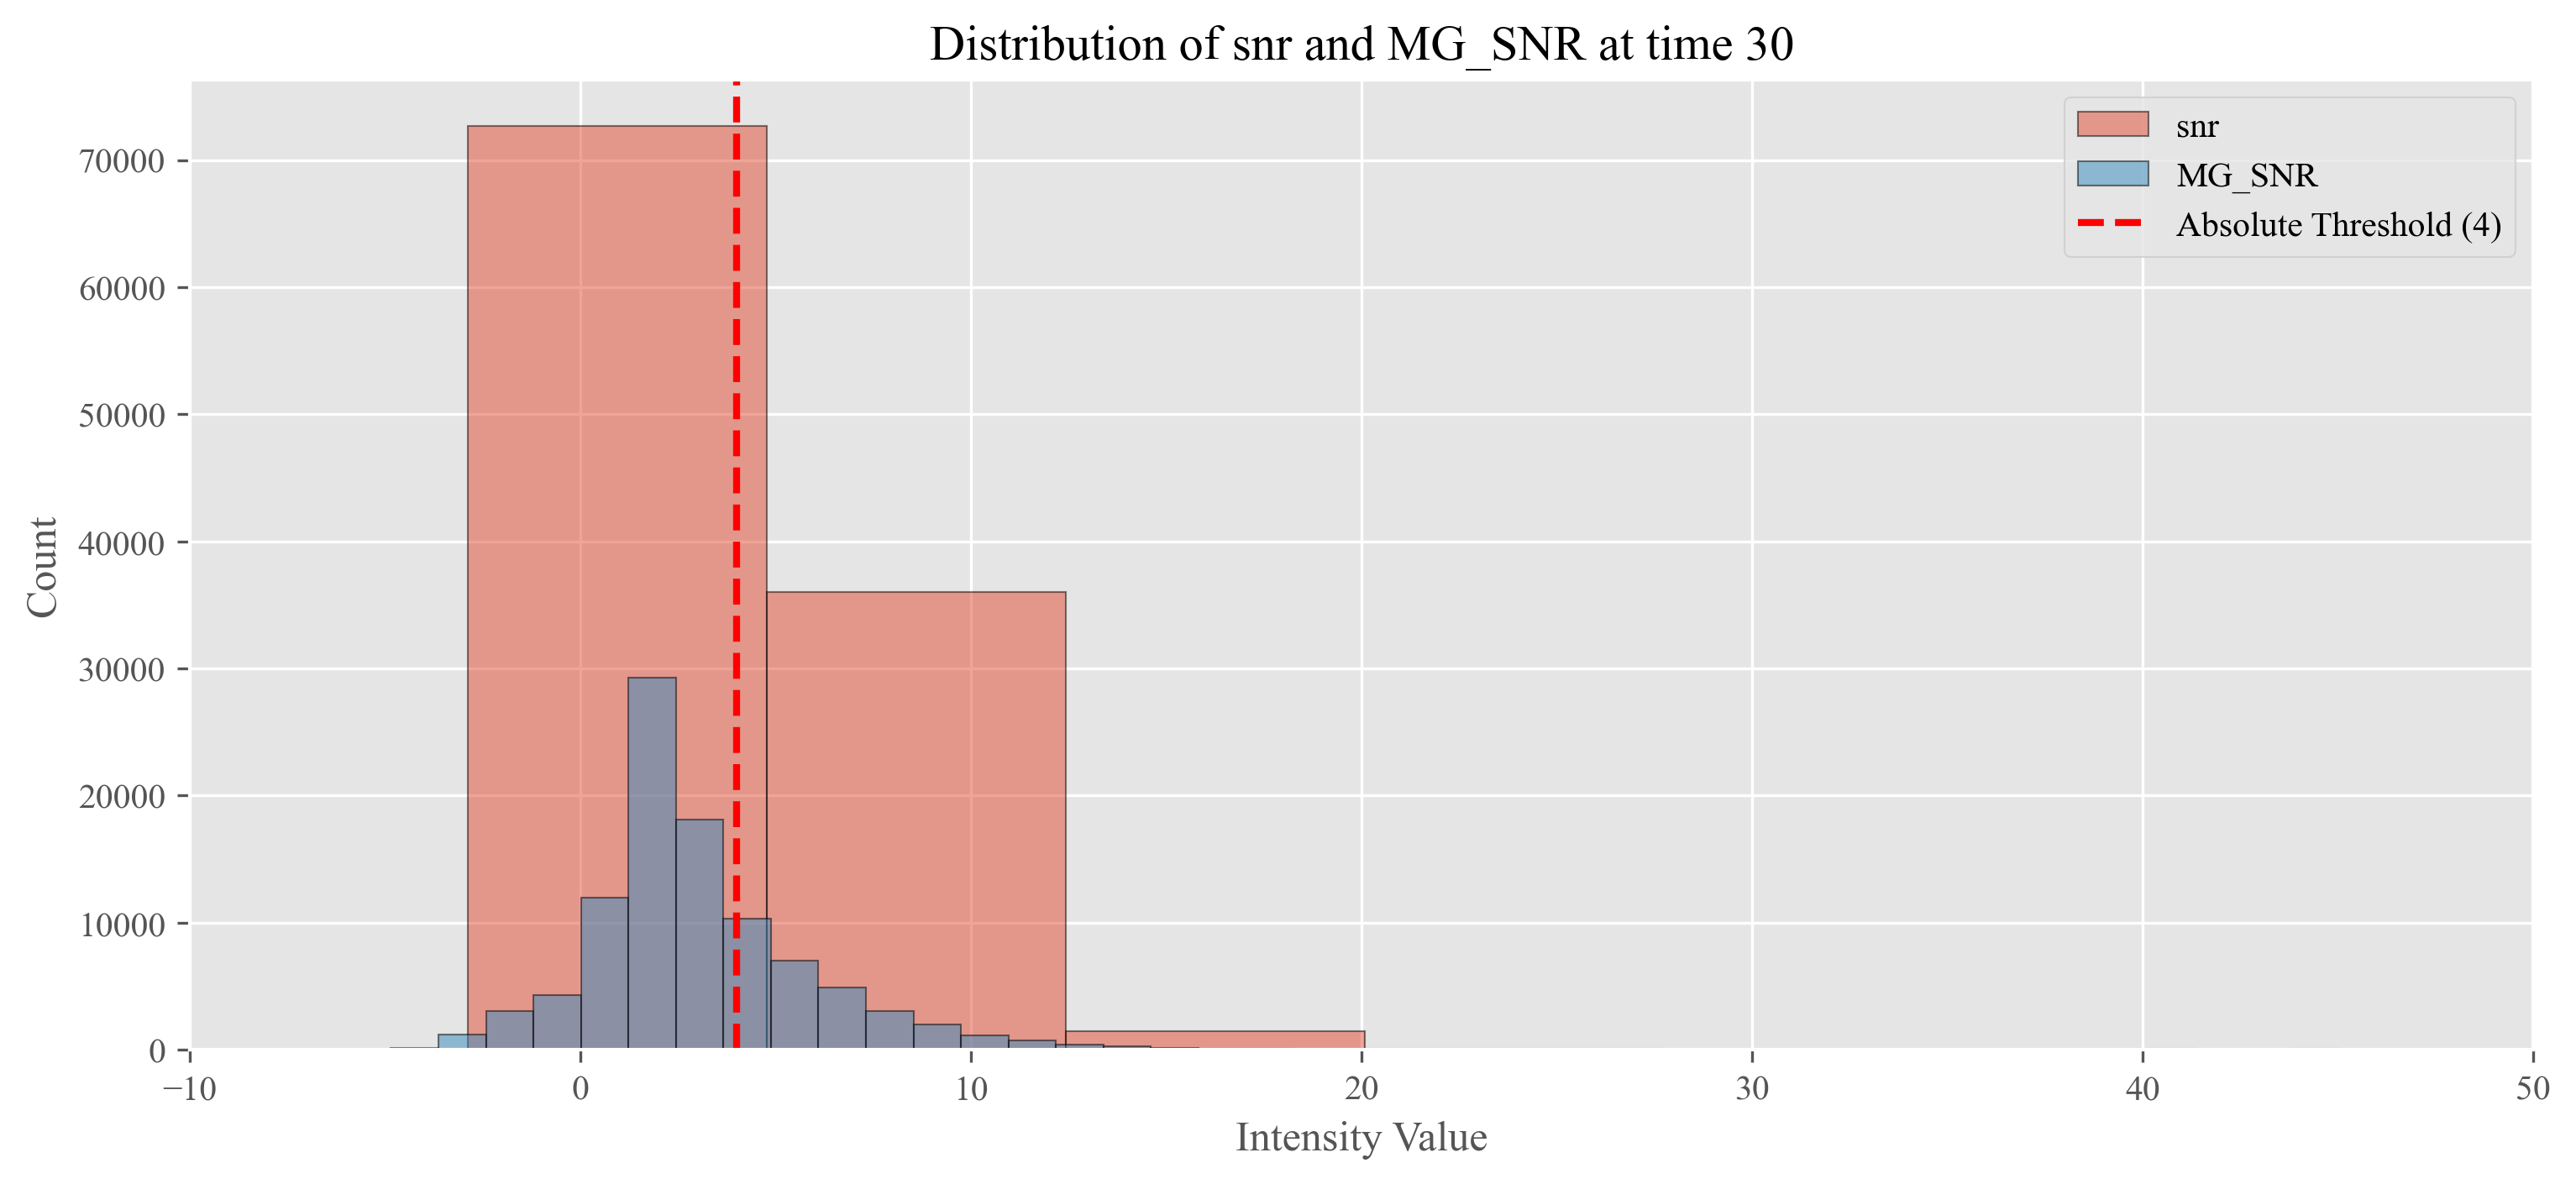

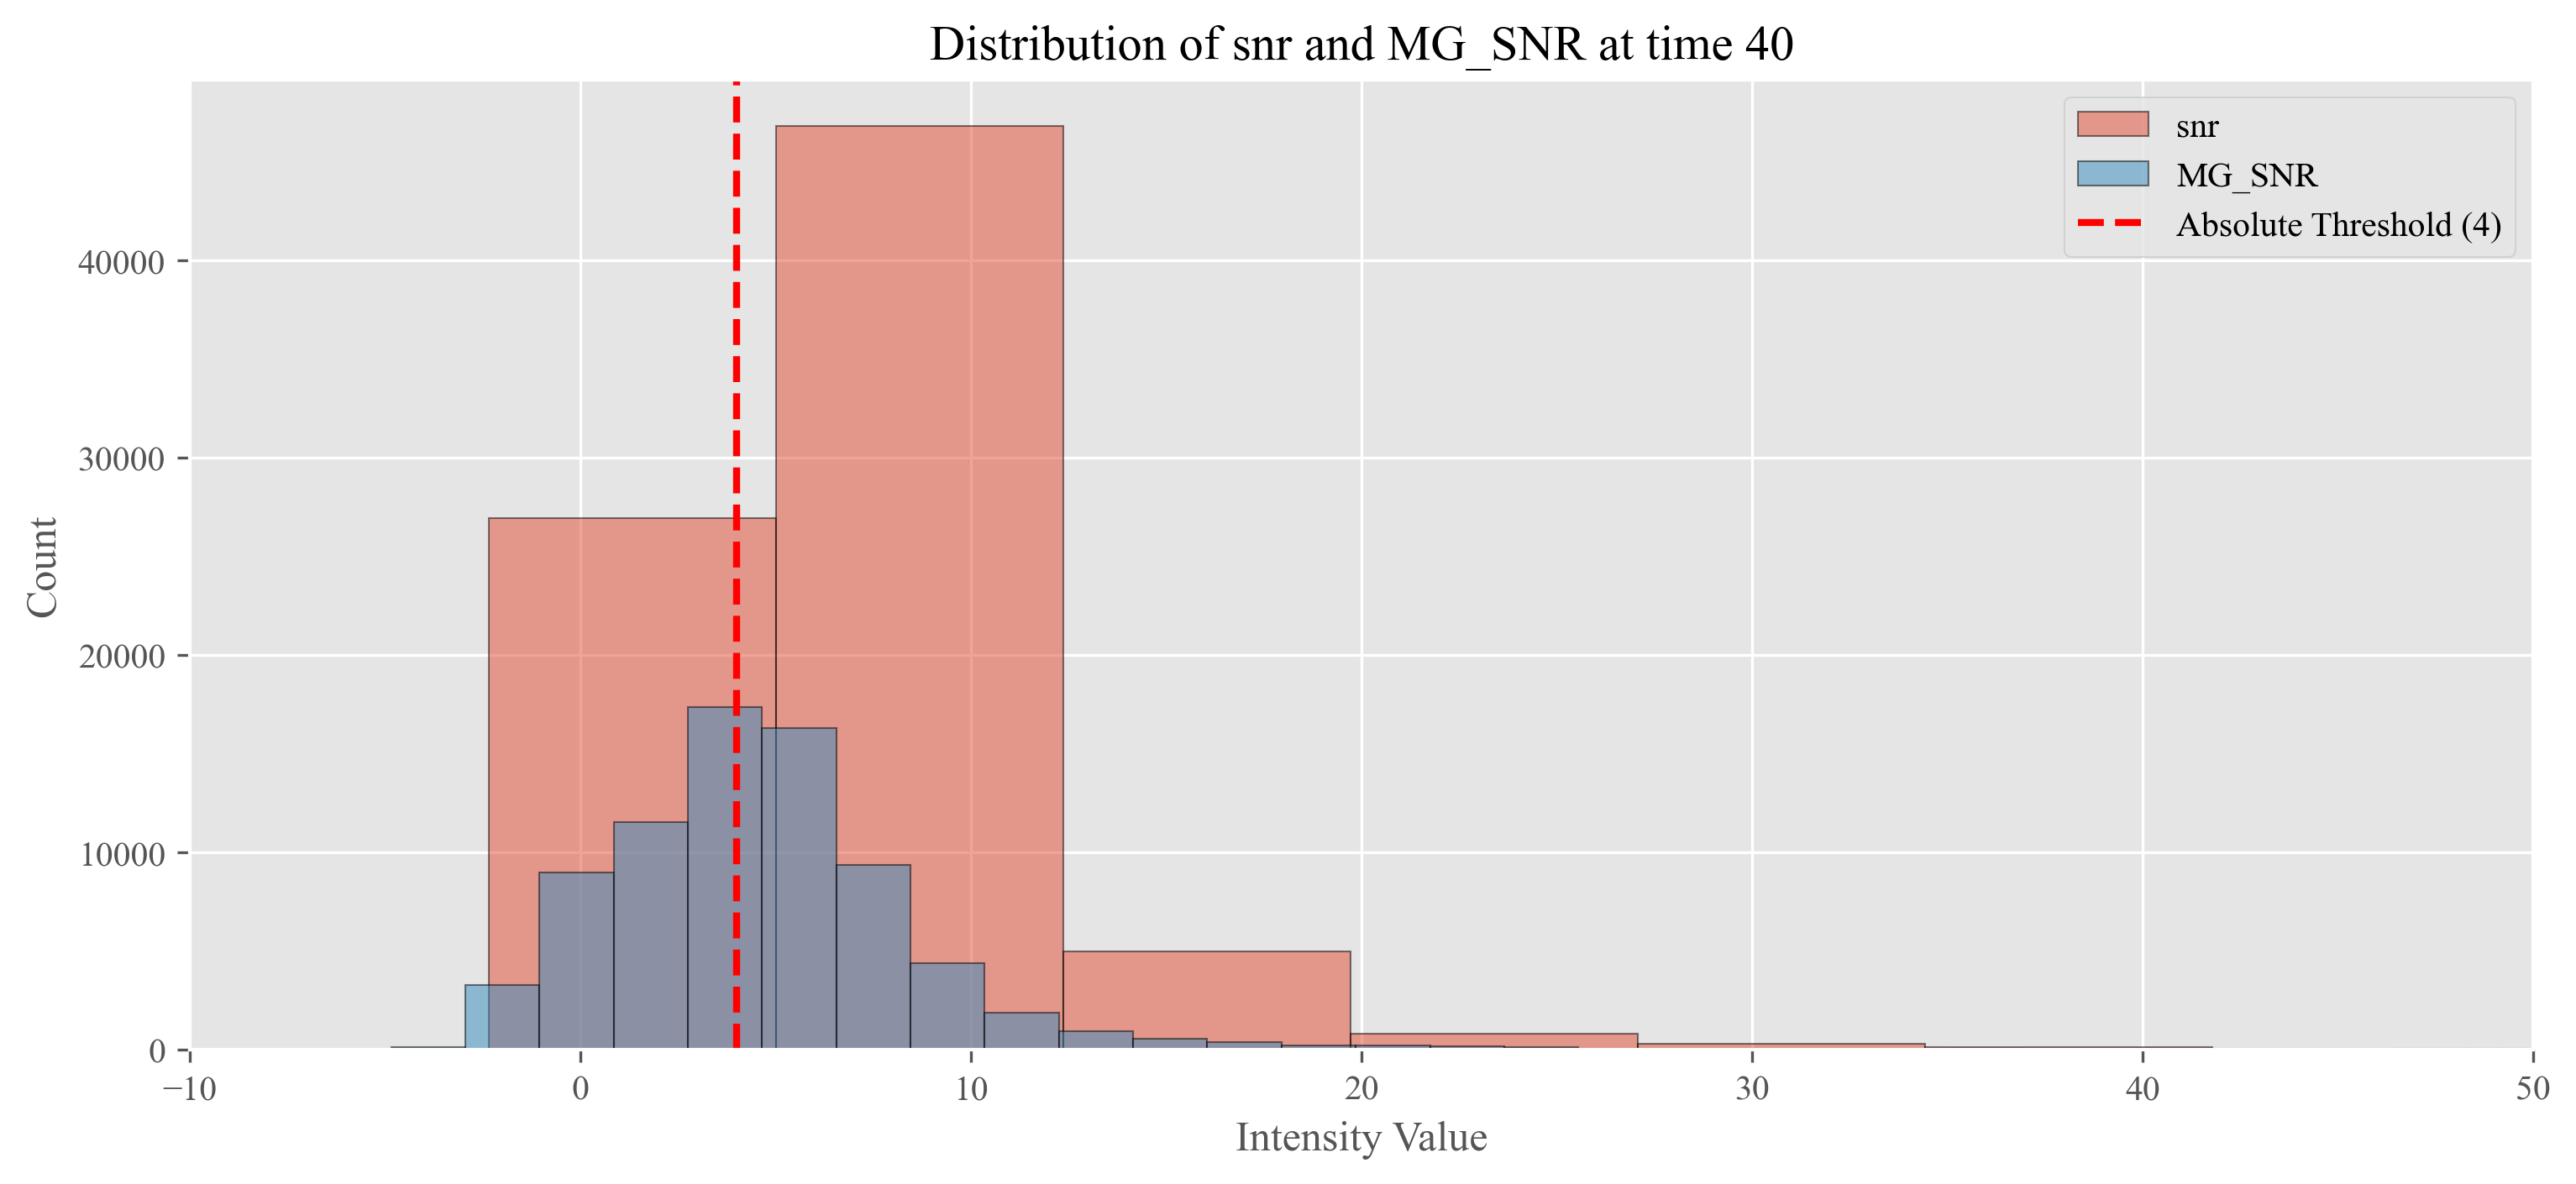

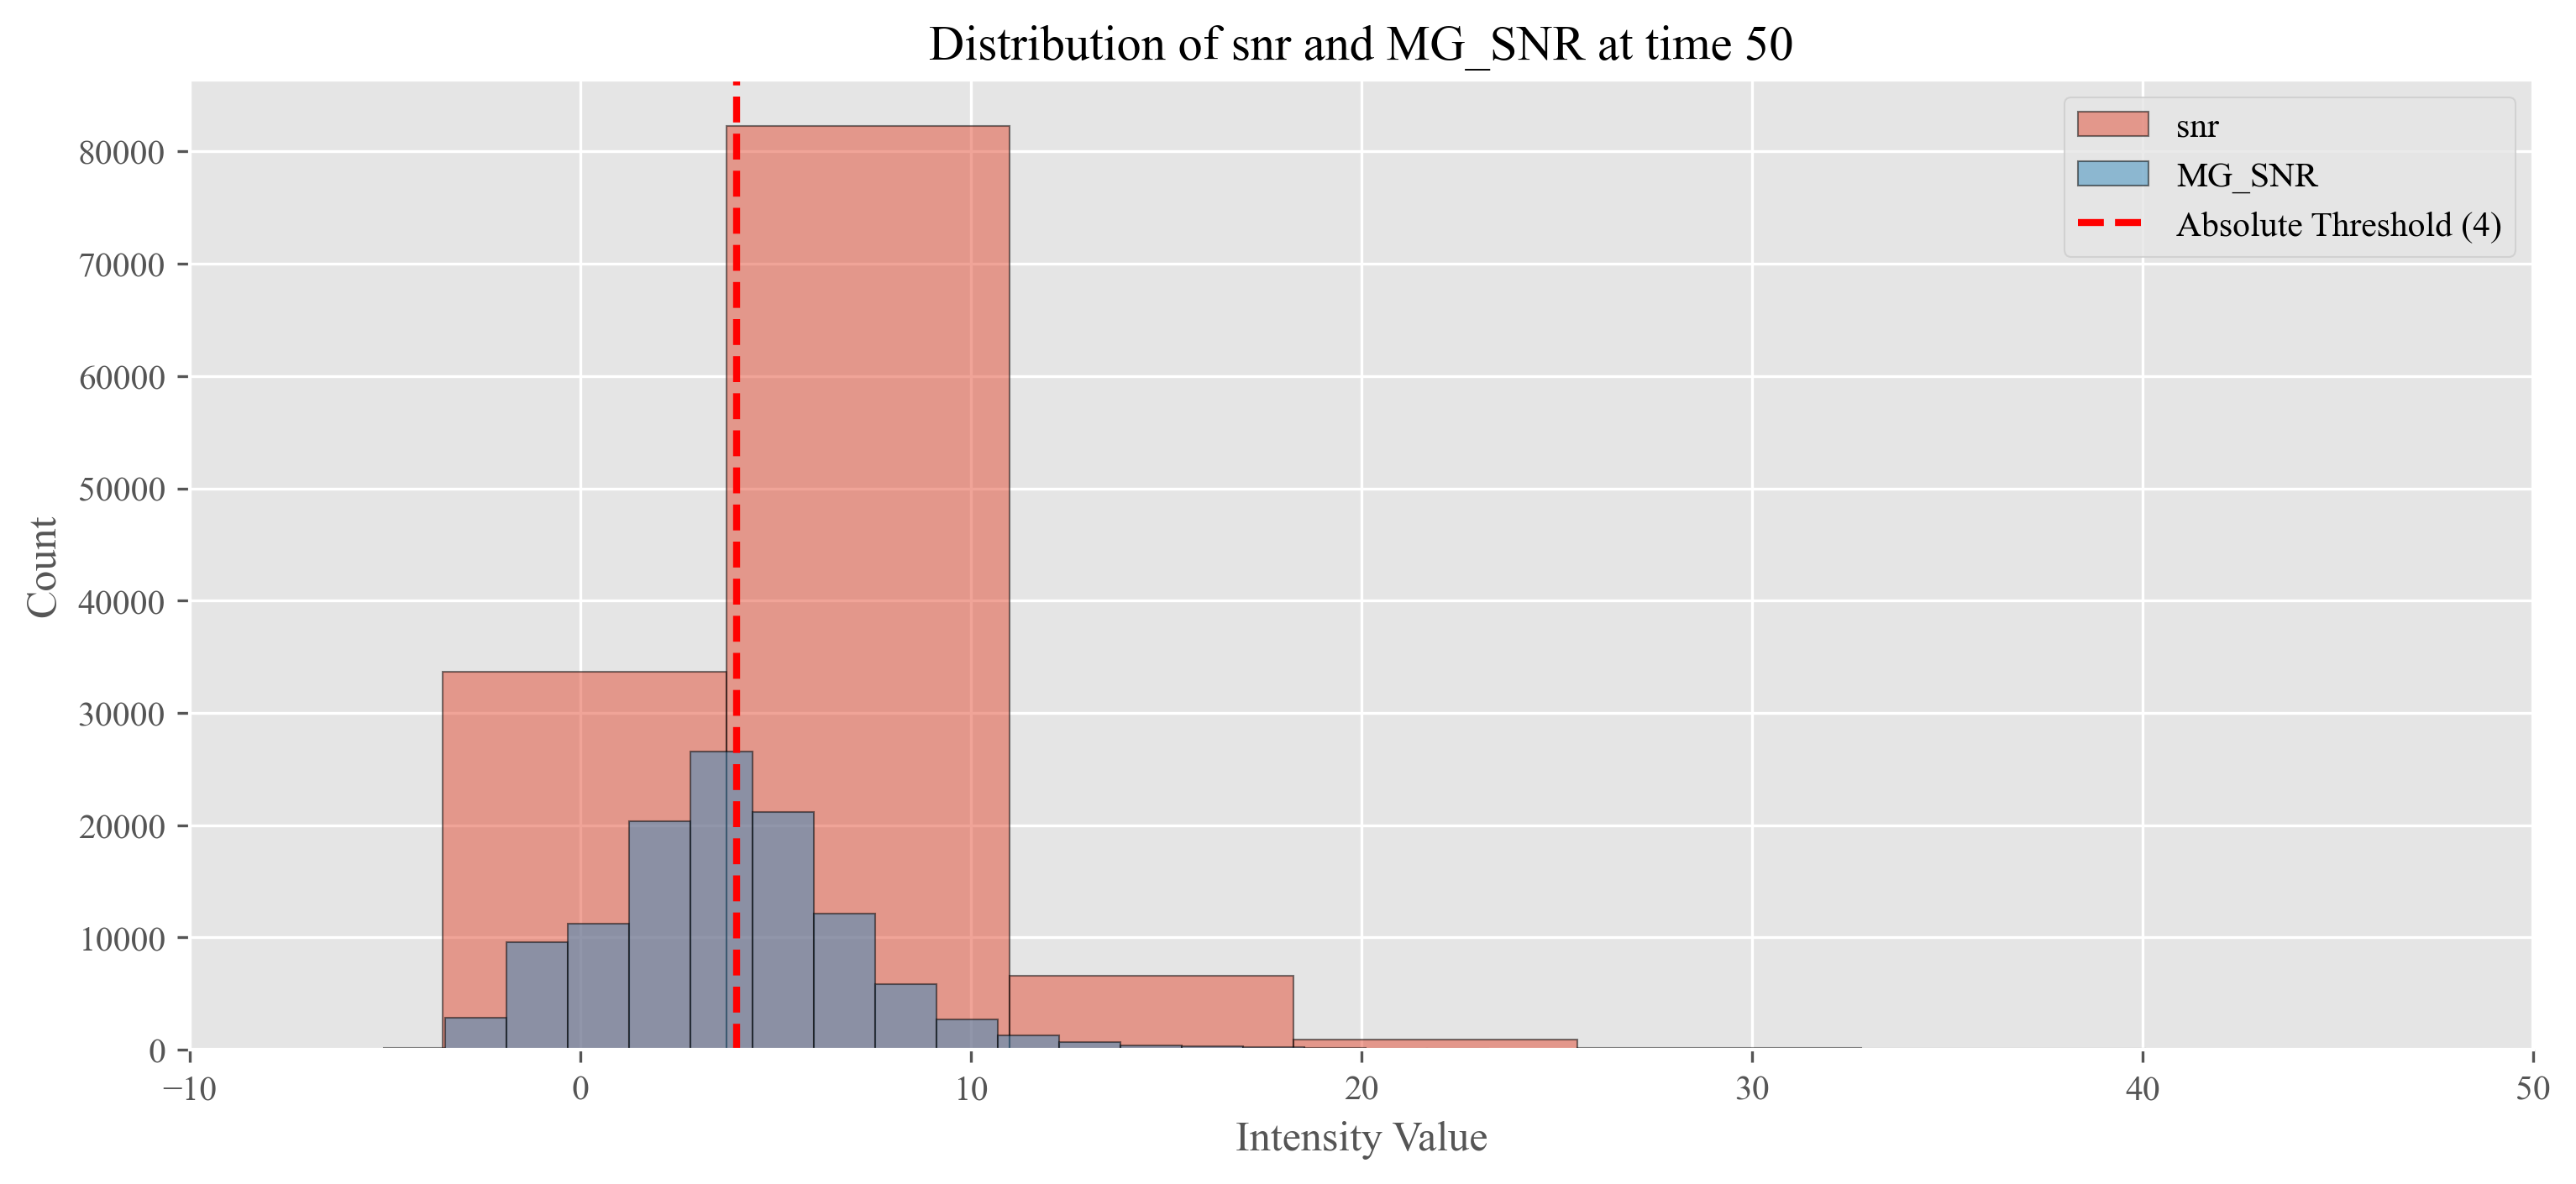

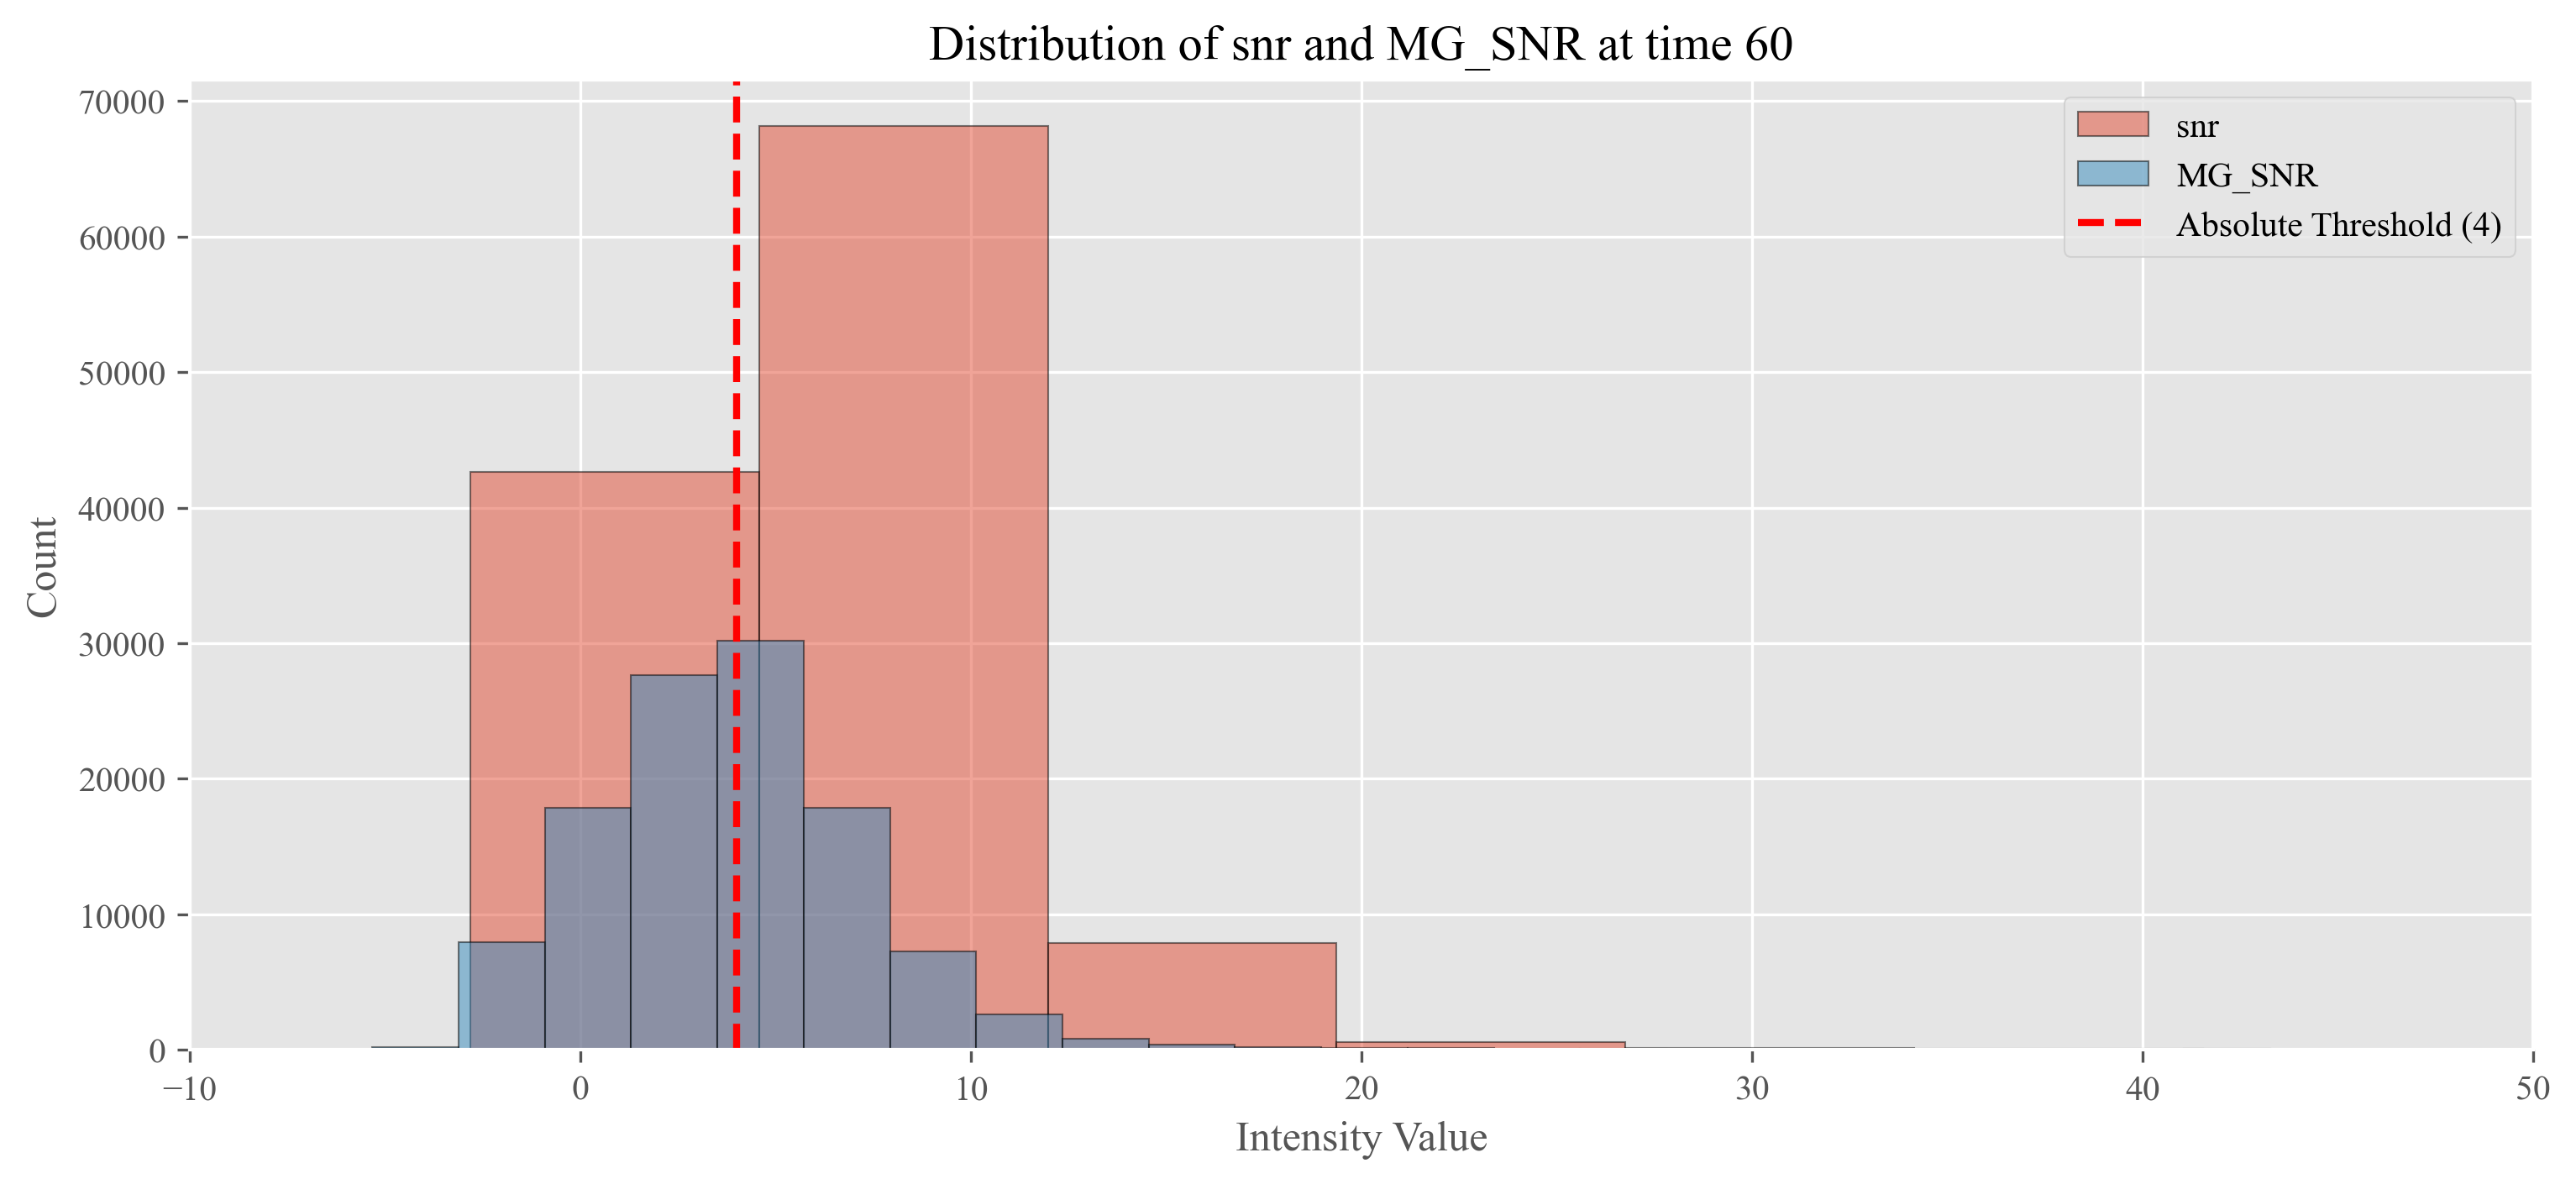

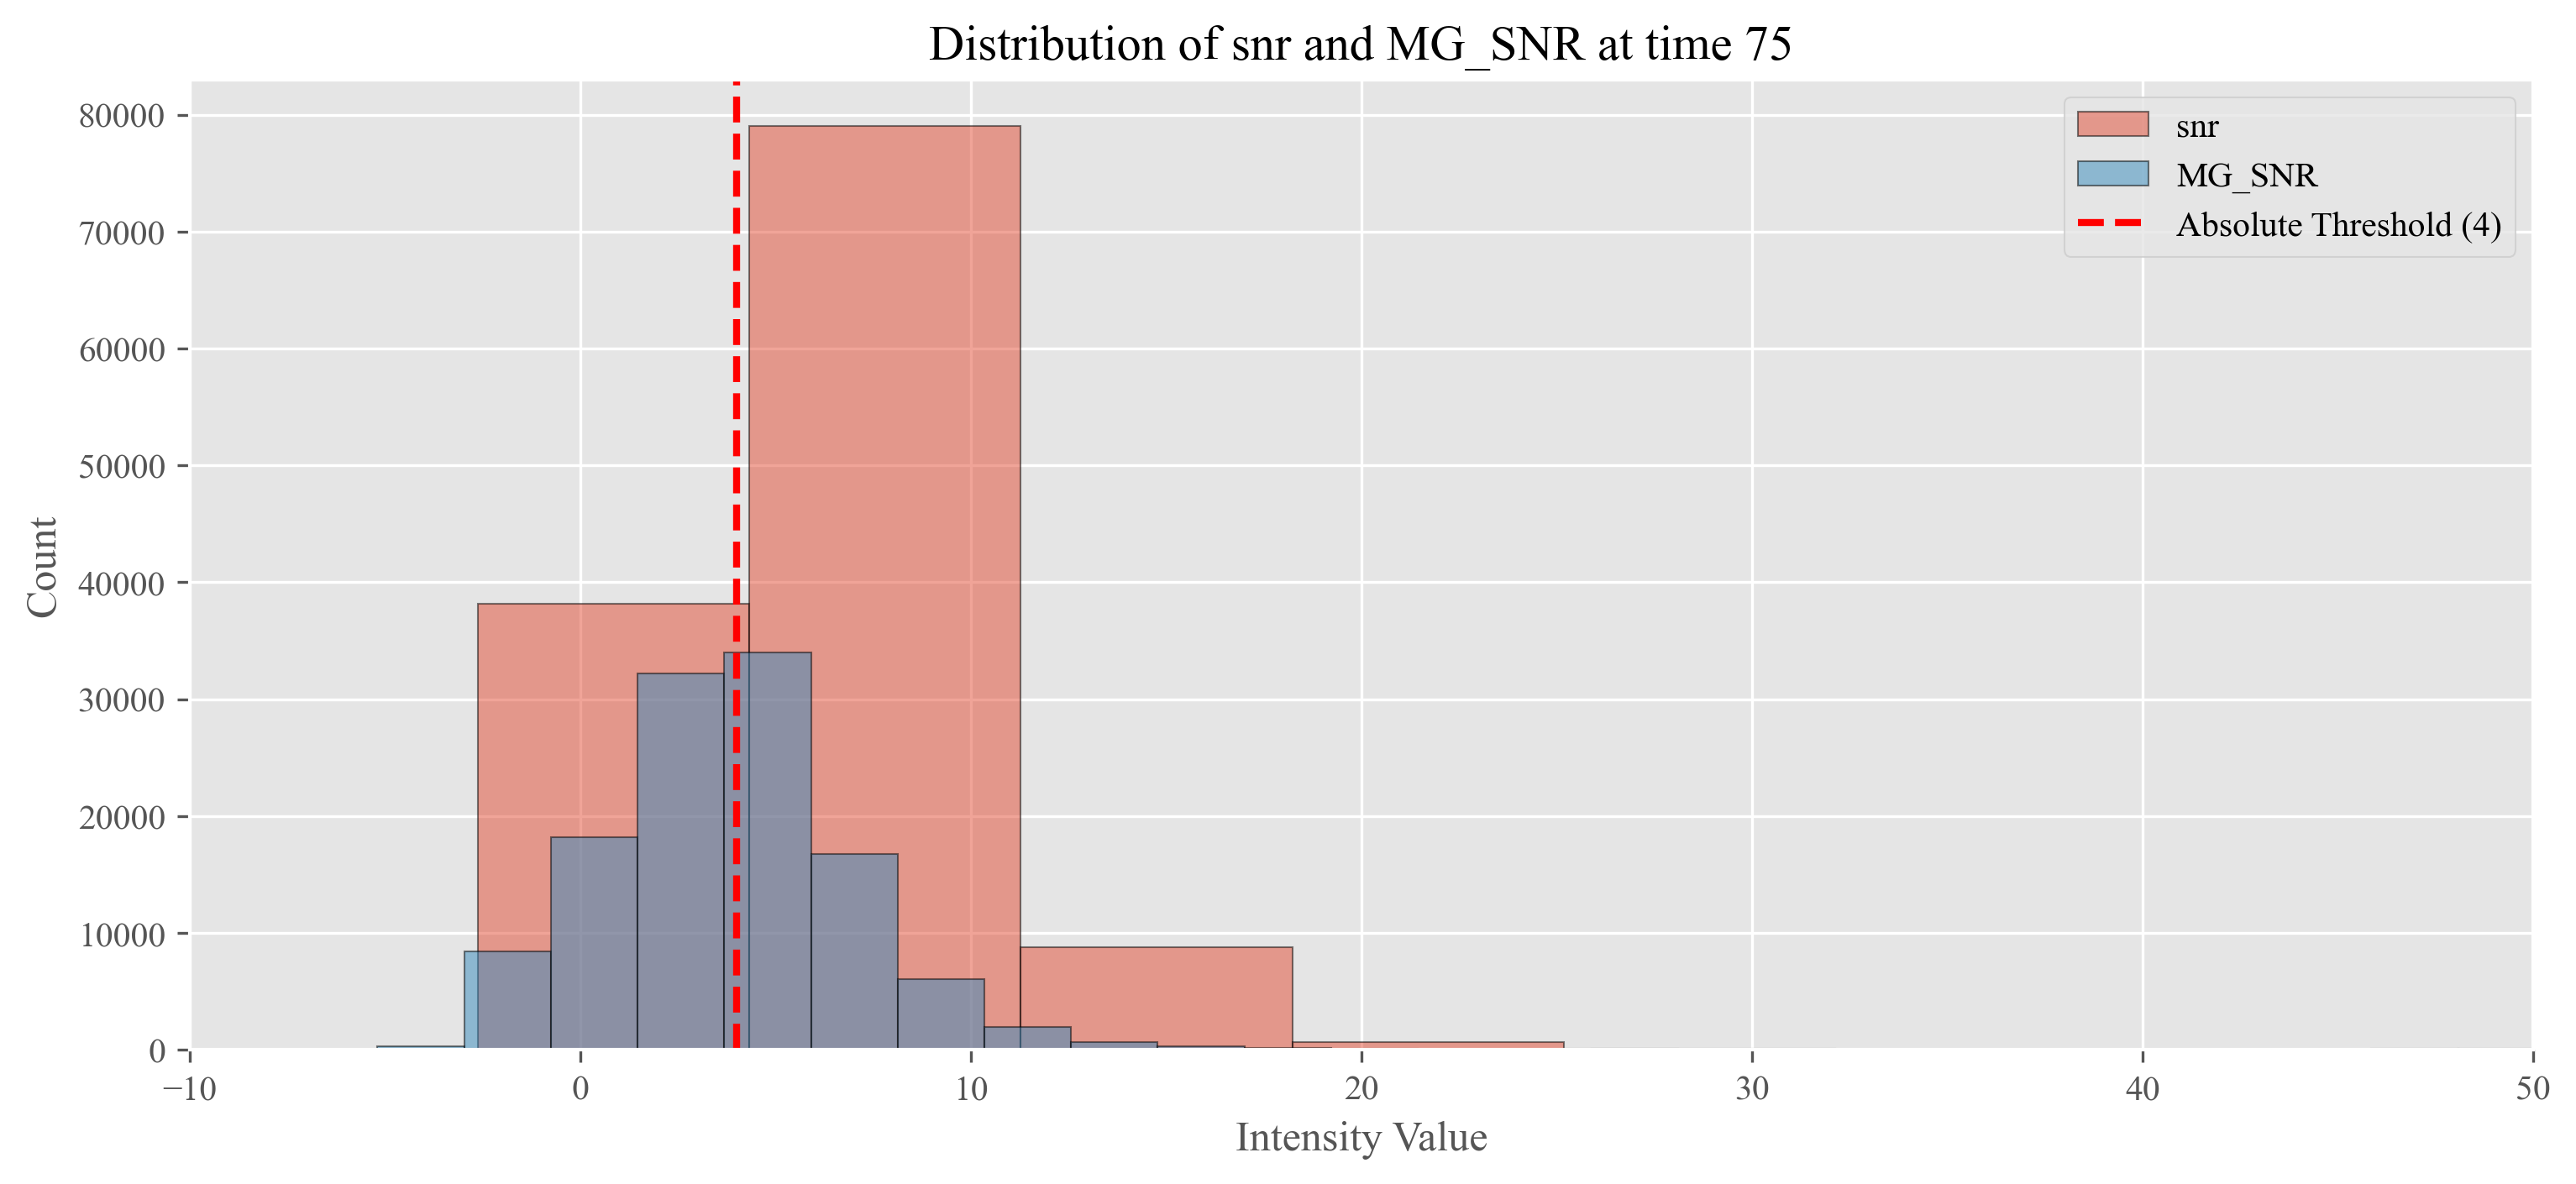

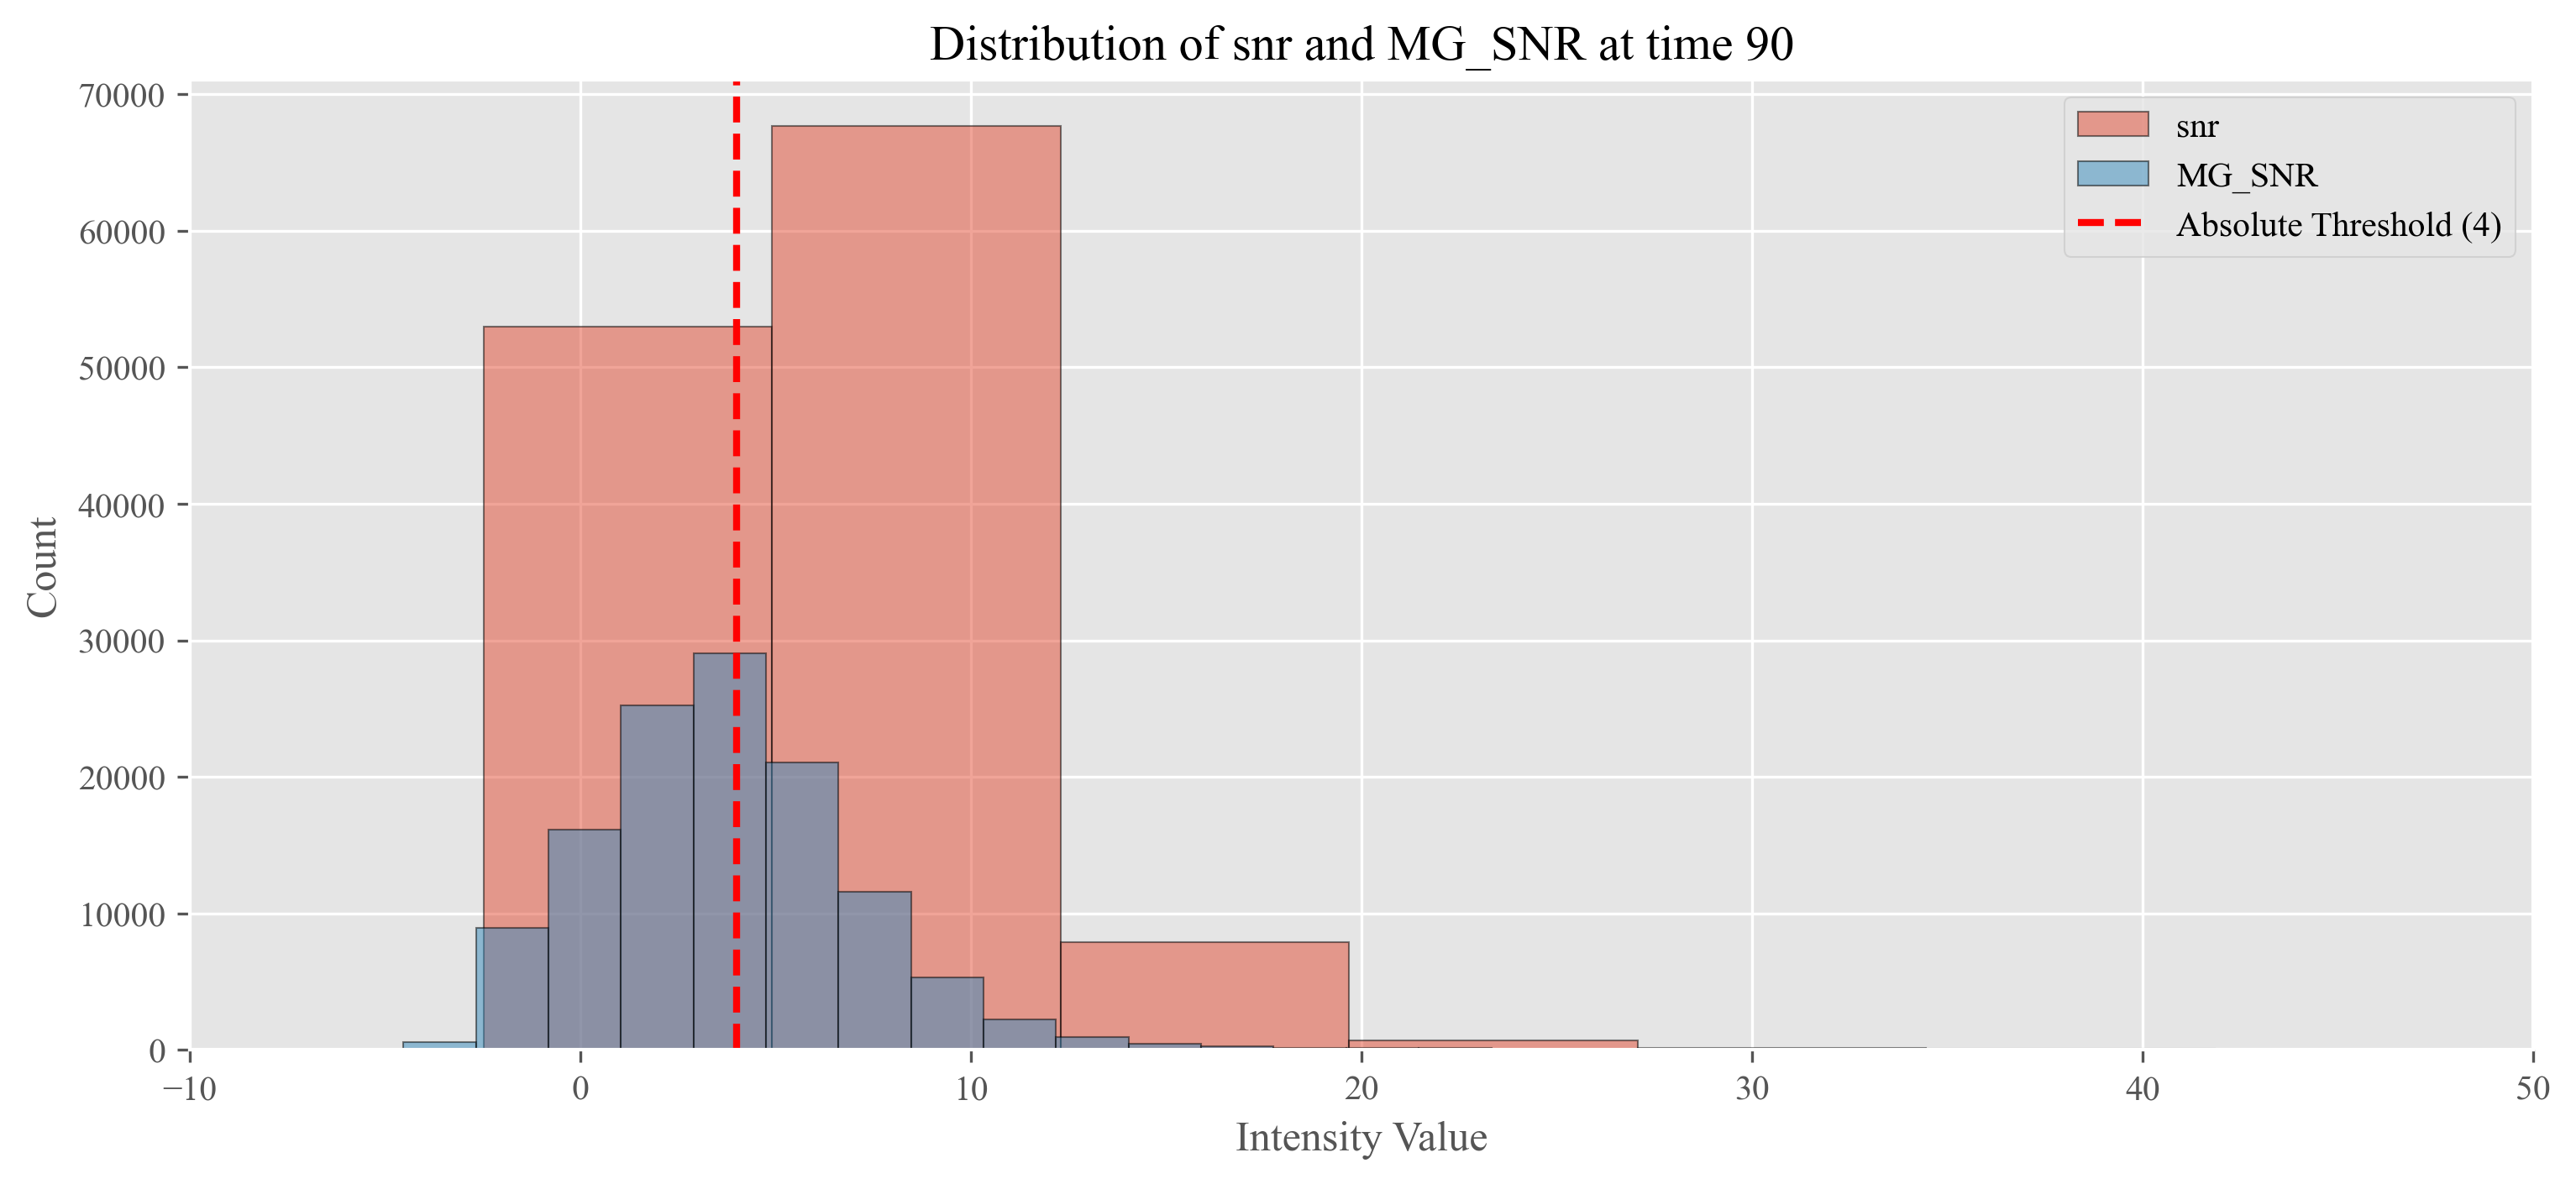

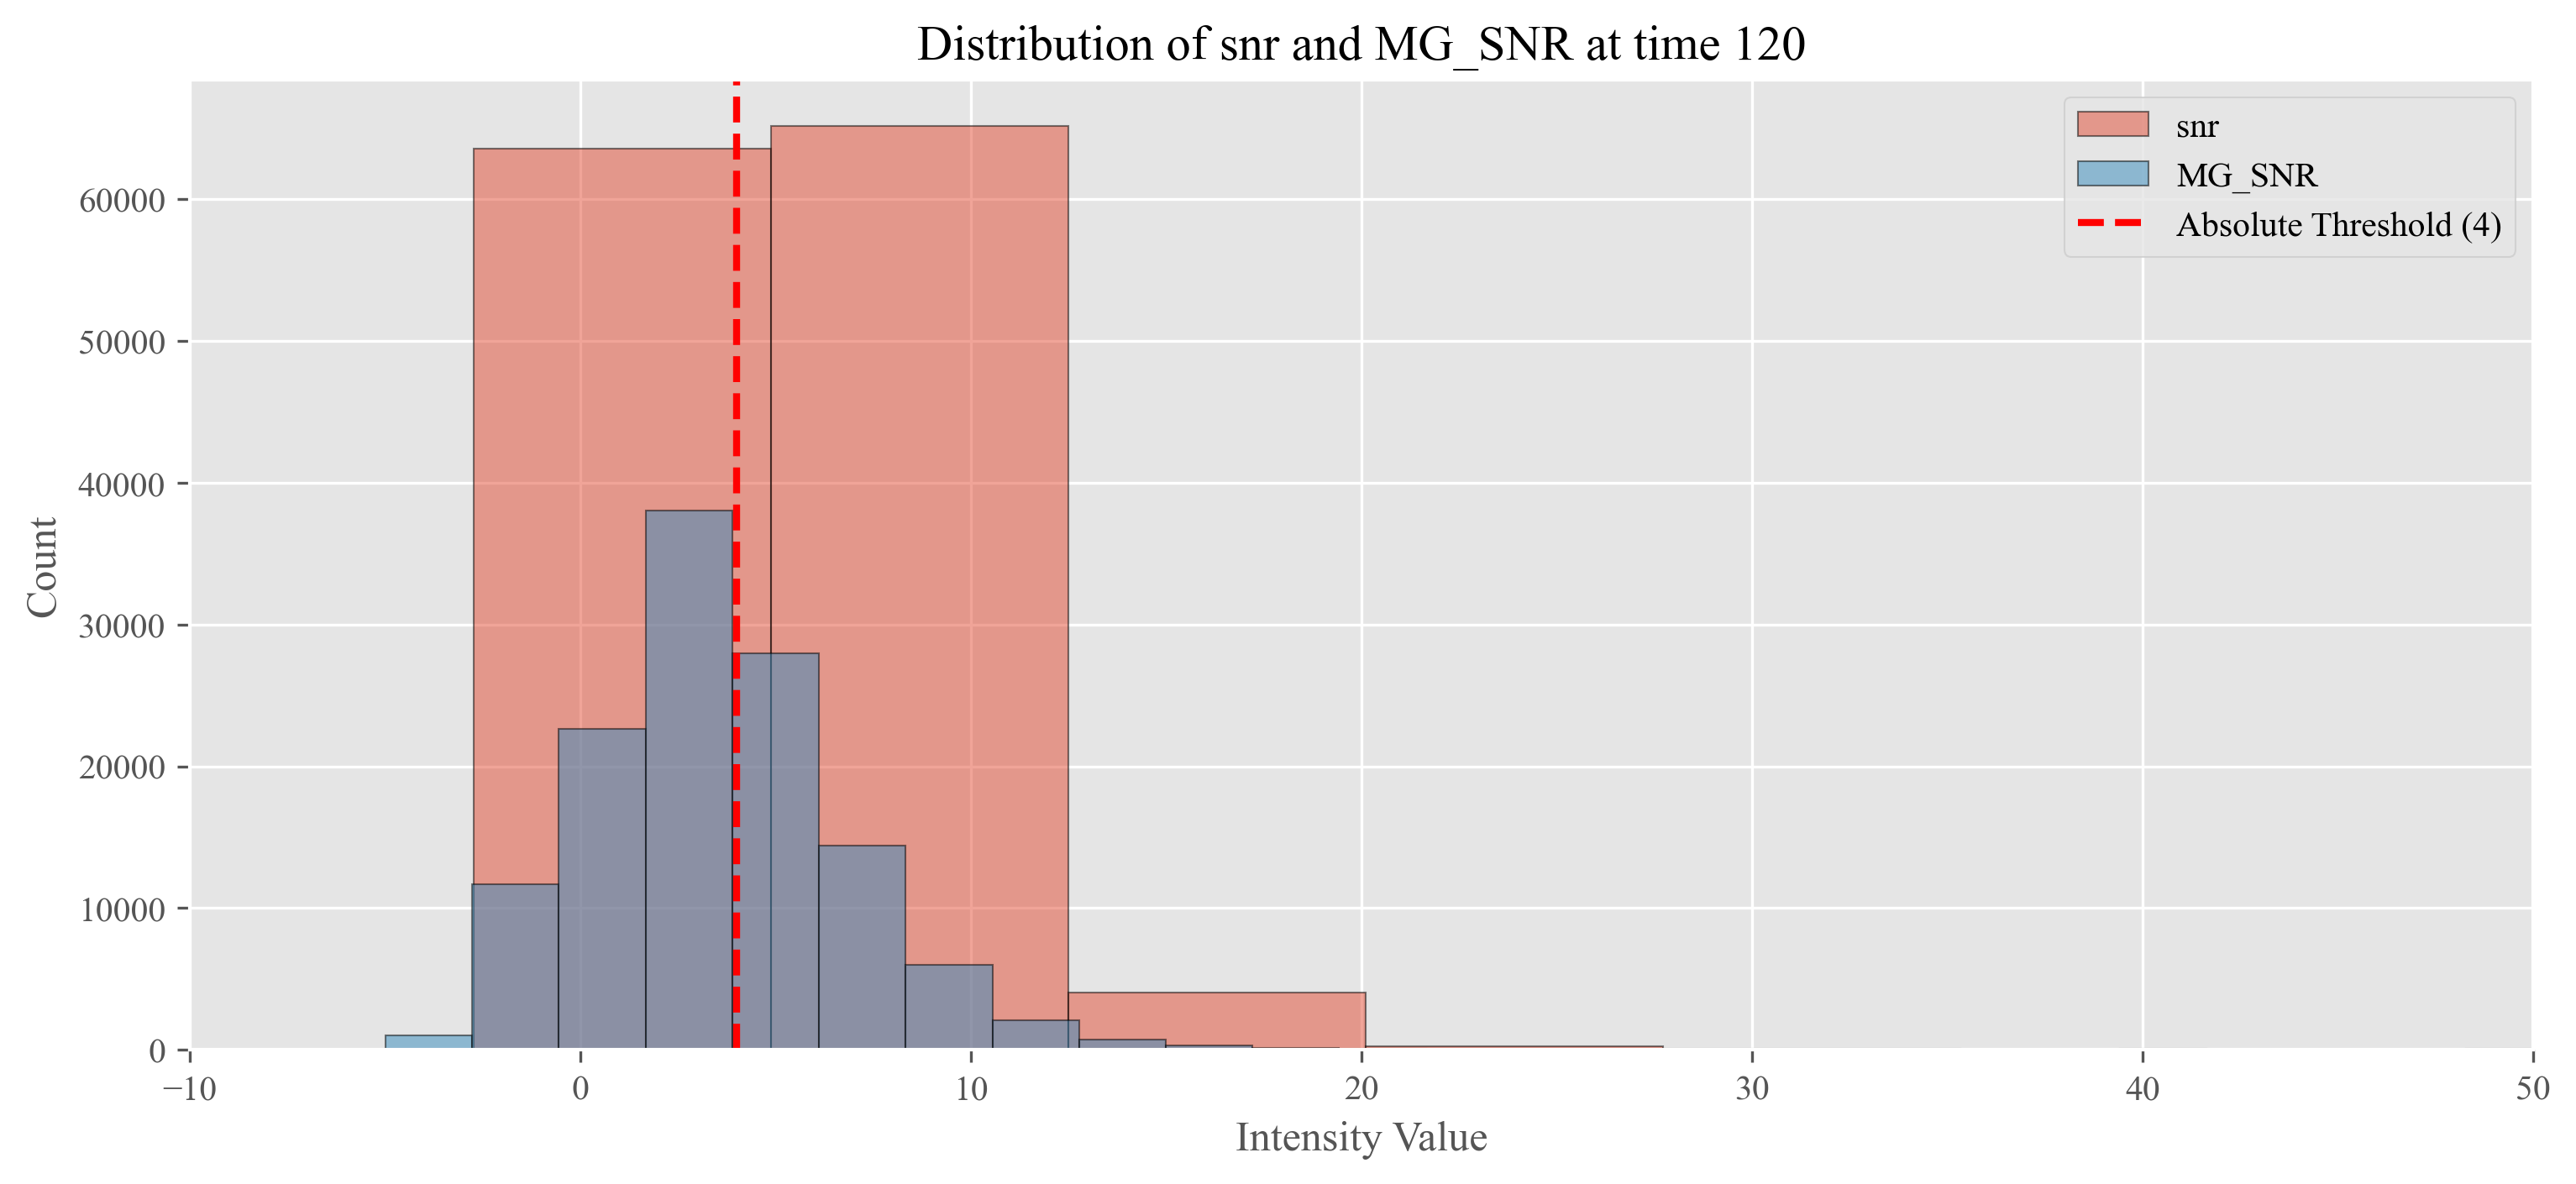

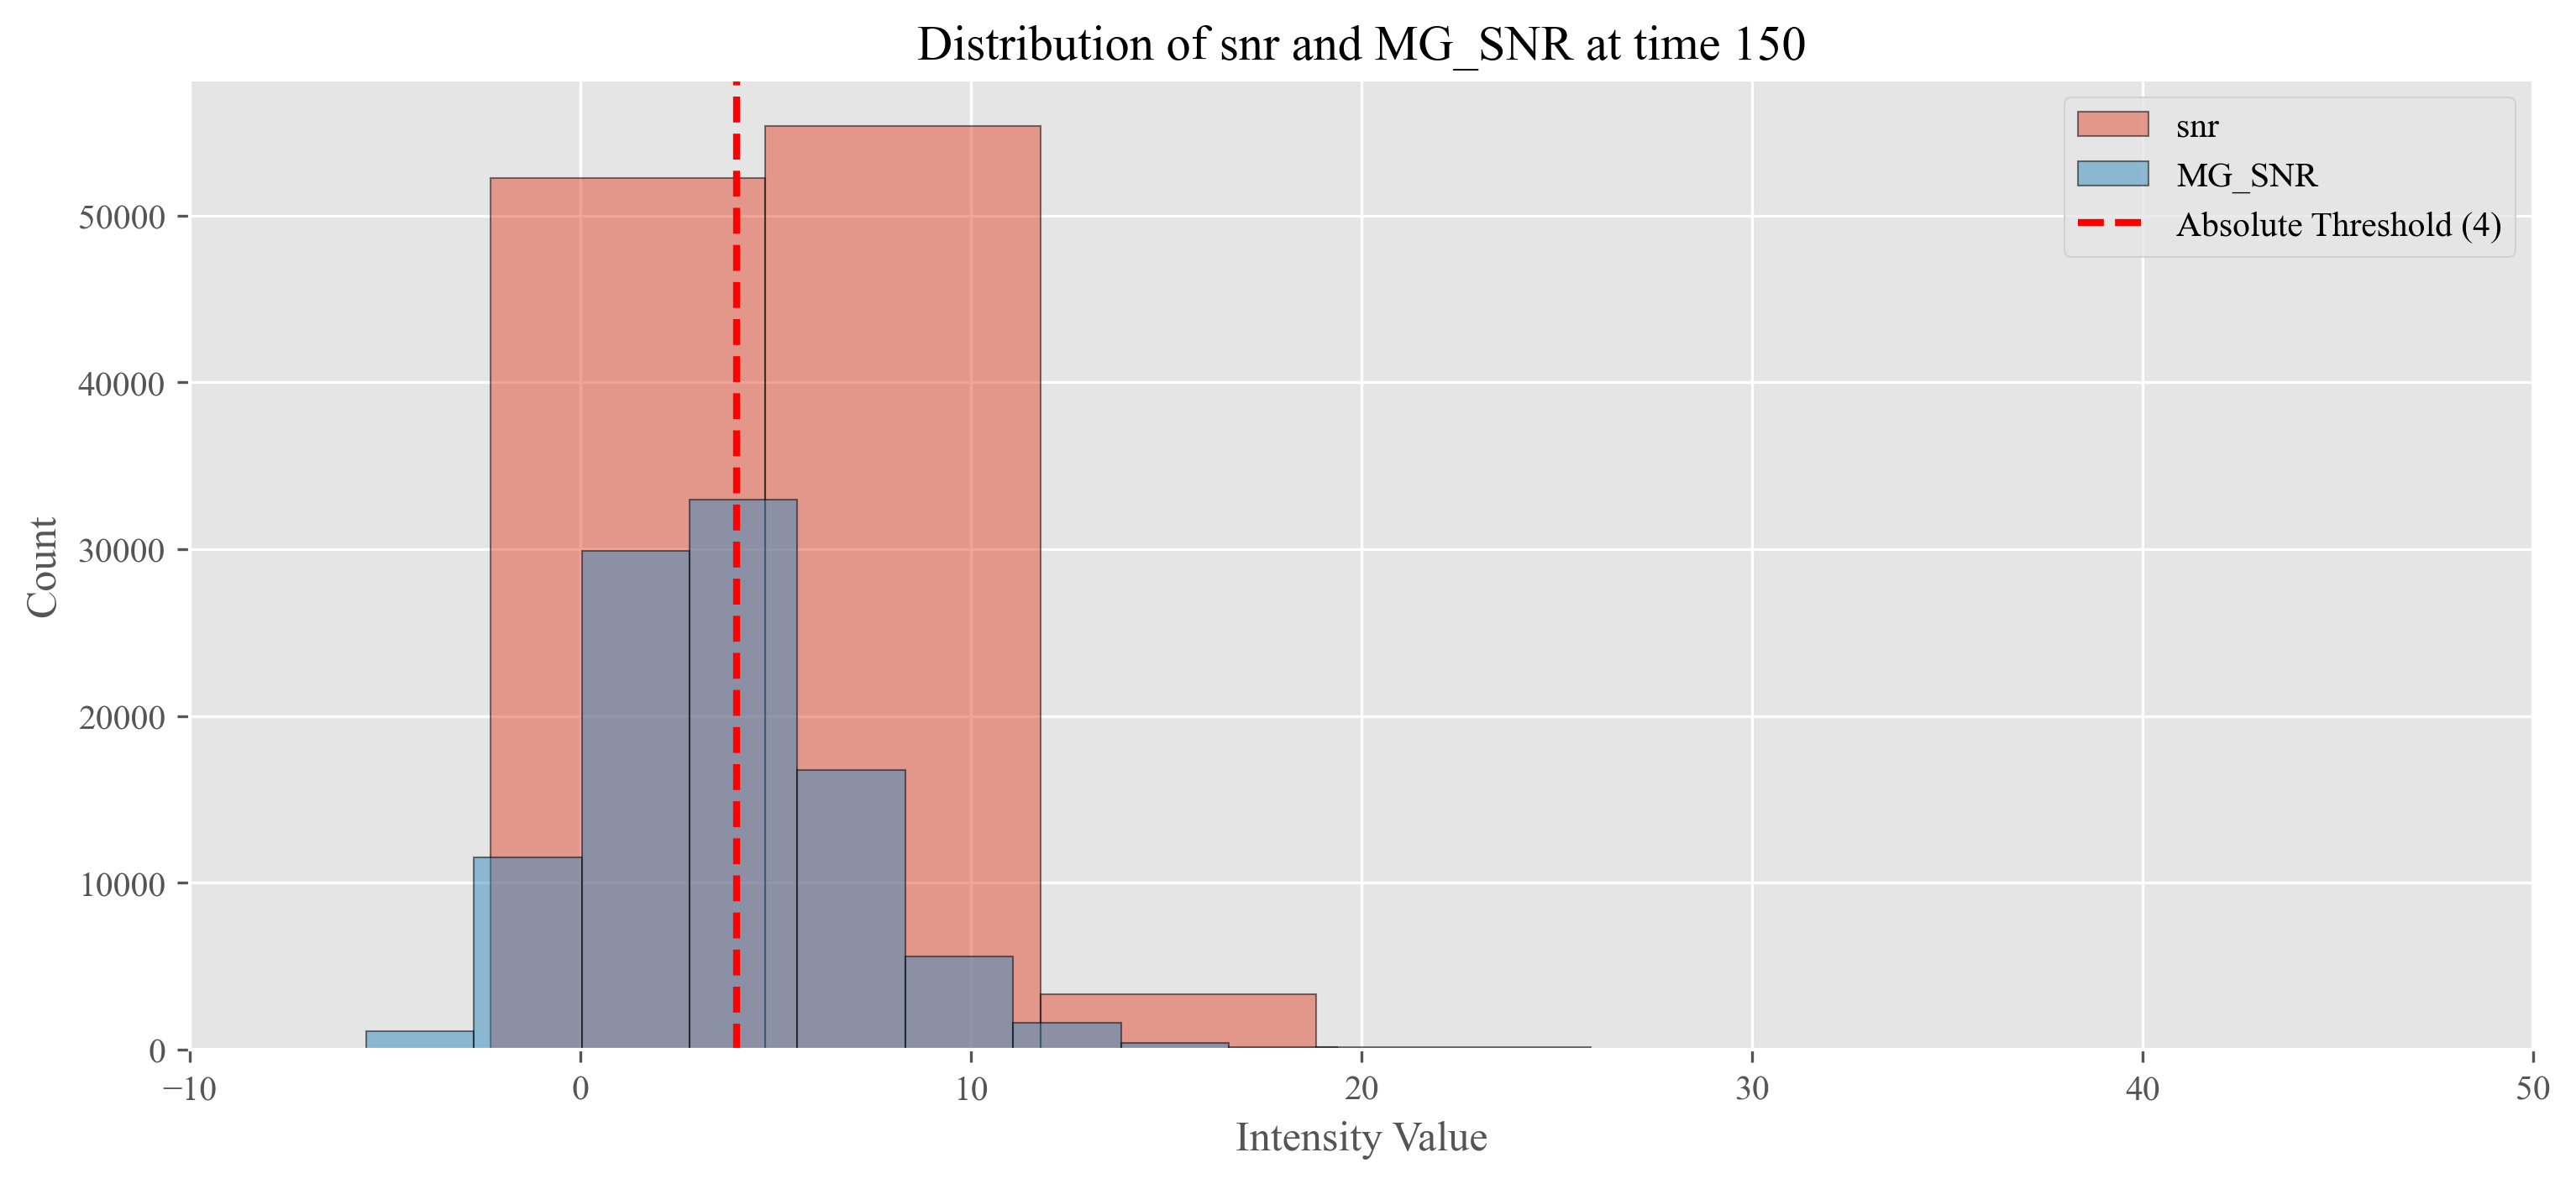

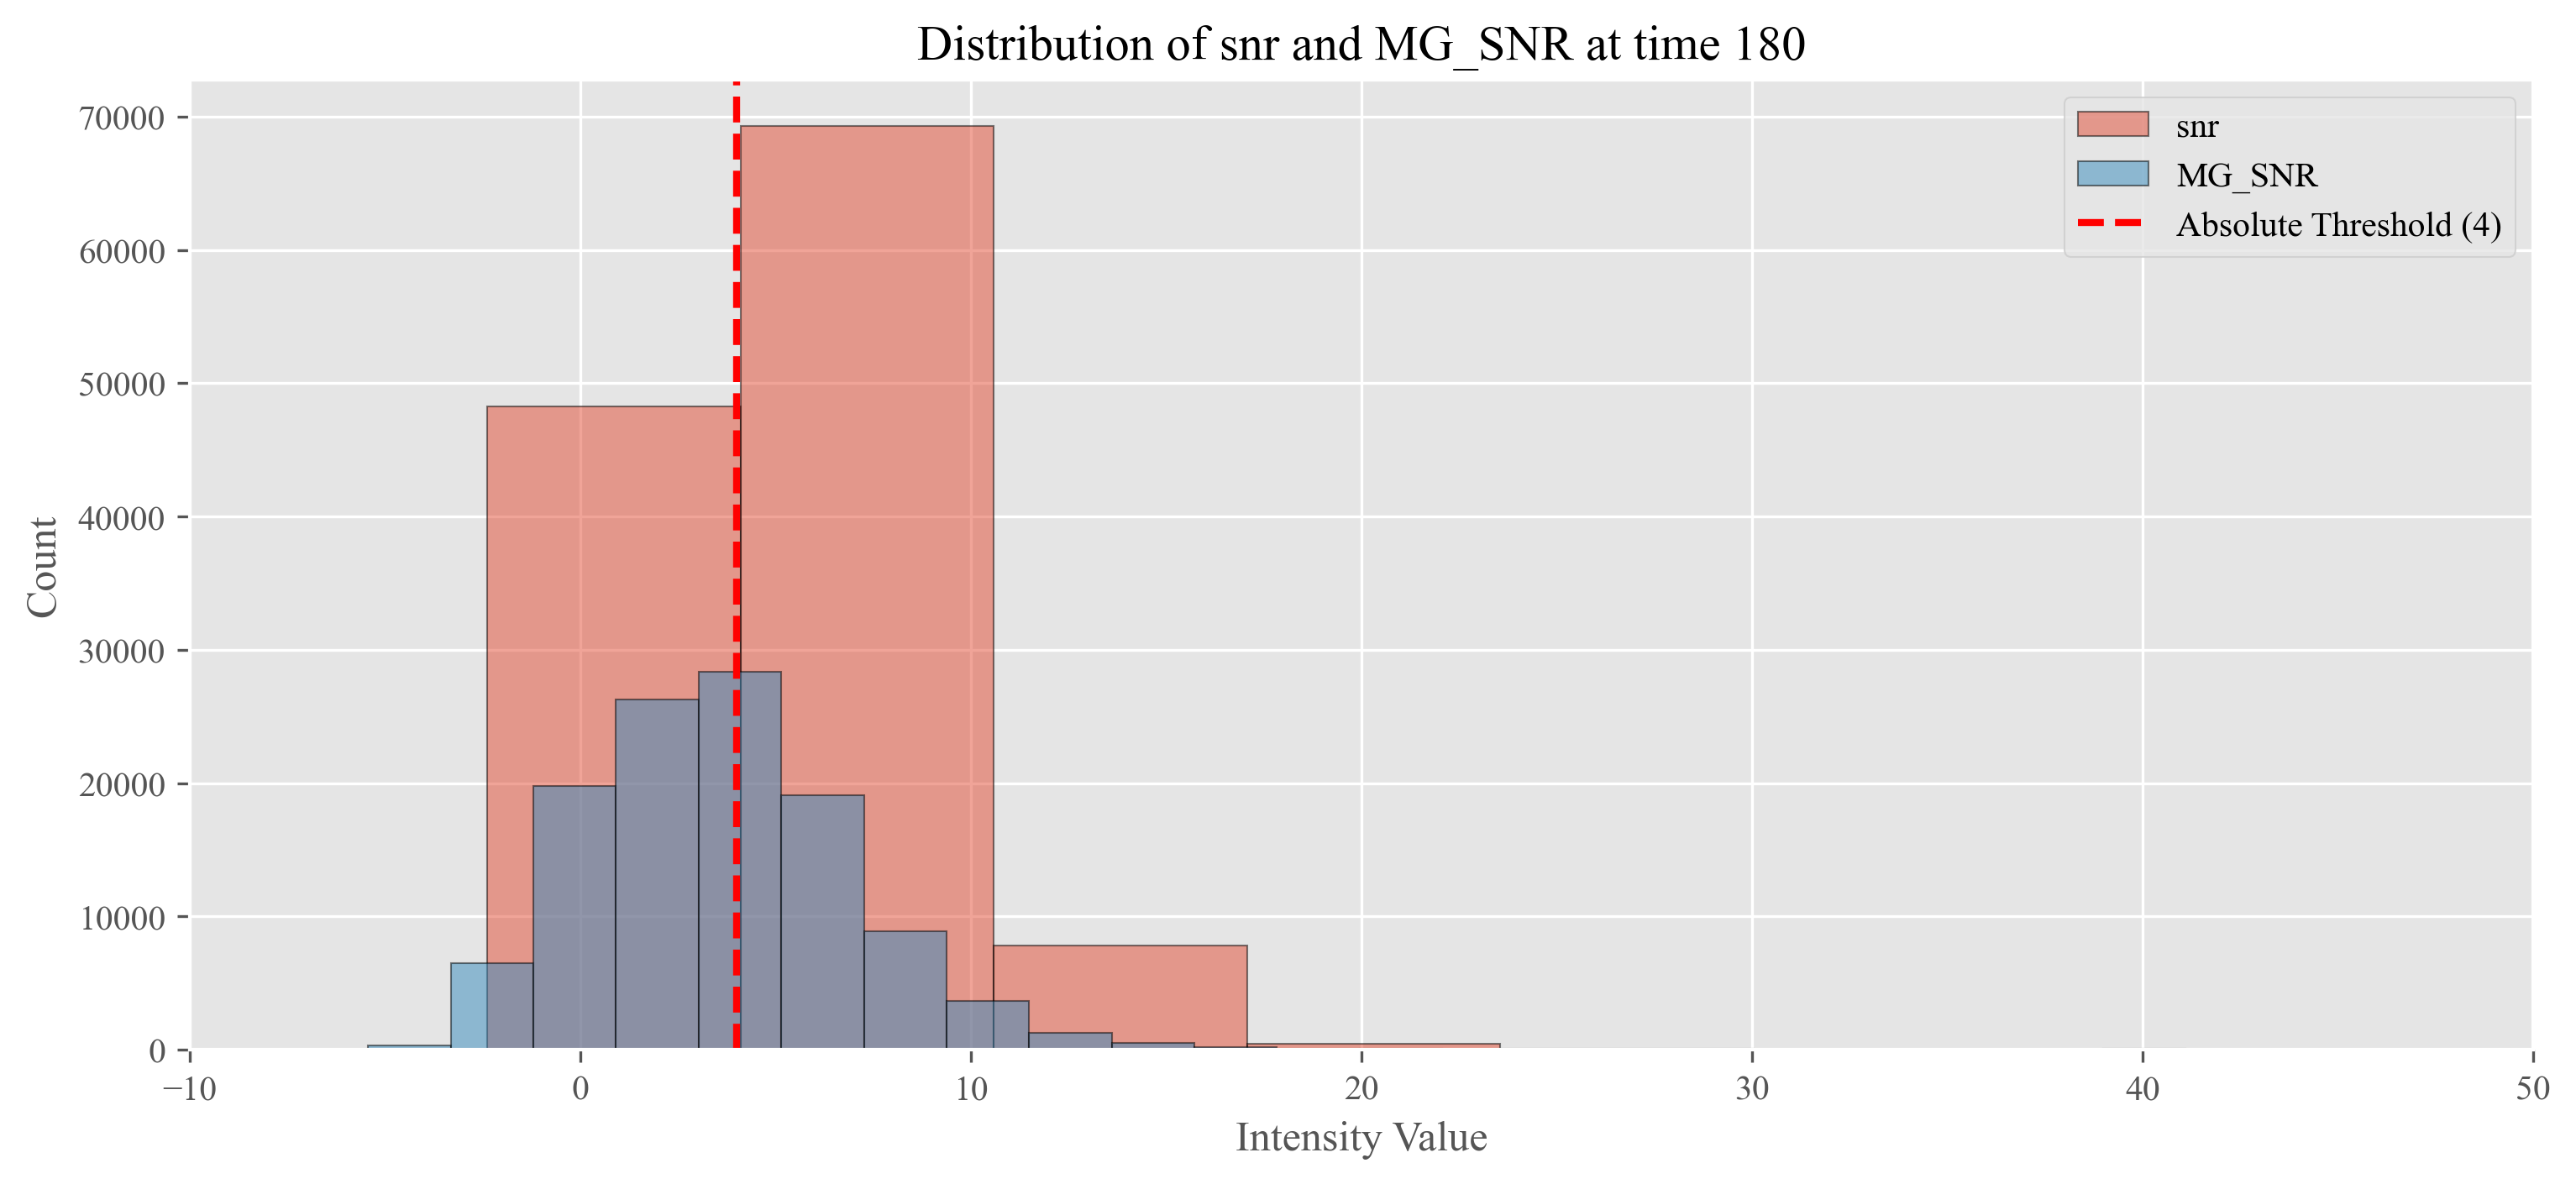

In [15]:
# Get the unique time points and sort them.
unique_times = sorted(merged_spots_df['time'].unique())

for t in unique_times:
    subset = merged_spots_df[merged_spots_df['time'] == t]
    plt.figure(figsize=(12, 5))
    plt.hist(subset['snr'], bins=50, alpha=0.5, edgecolor='black', label='snr')
    plt.hist(subset['MG_SNR'], bins=50, alpha=0.5, edgecolor='black', label='MG_SNR')
    plt.axvline(4, color='red', linestyle='dashed', linewidth=2, label='Absolute Threshold (4)')
    plt.title(f'Distribution of snr and MG_SNR at time {t}')
    plt.xlabel('Intensity Value')
    plt.xlim(-10, 50)
    plt.ylabel('Count')
    plt.legend()
    plt.show()

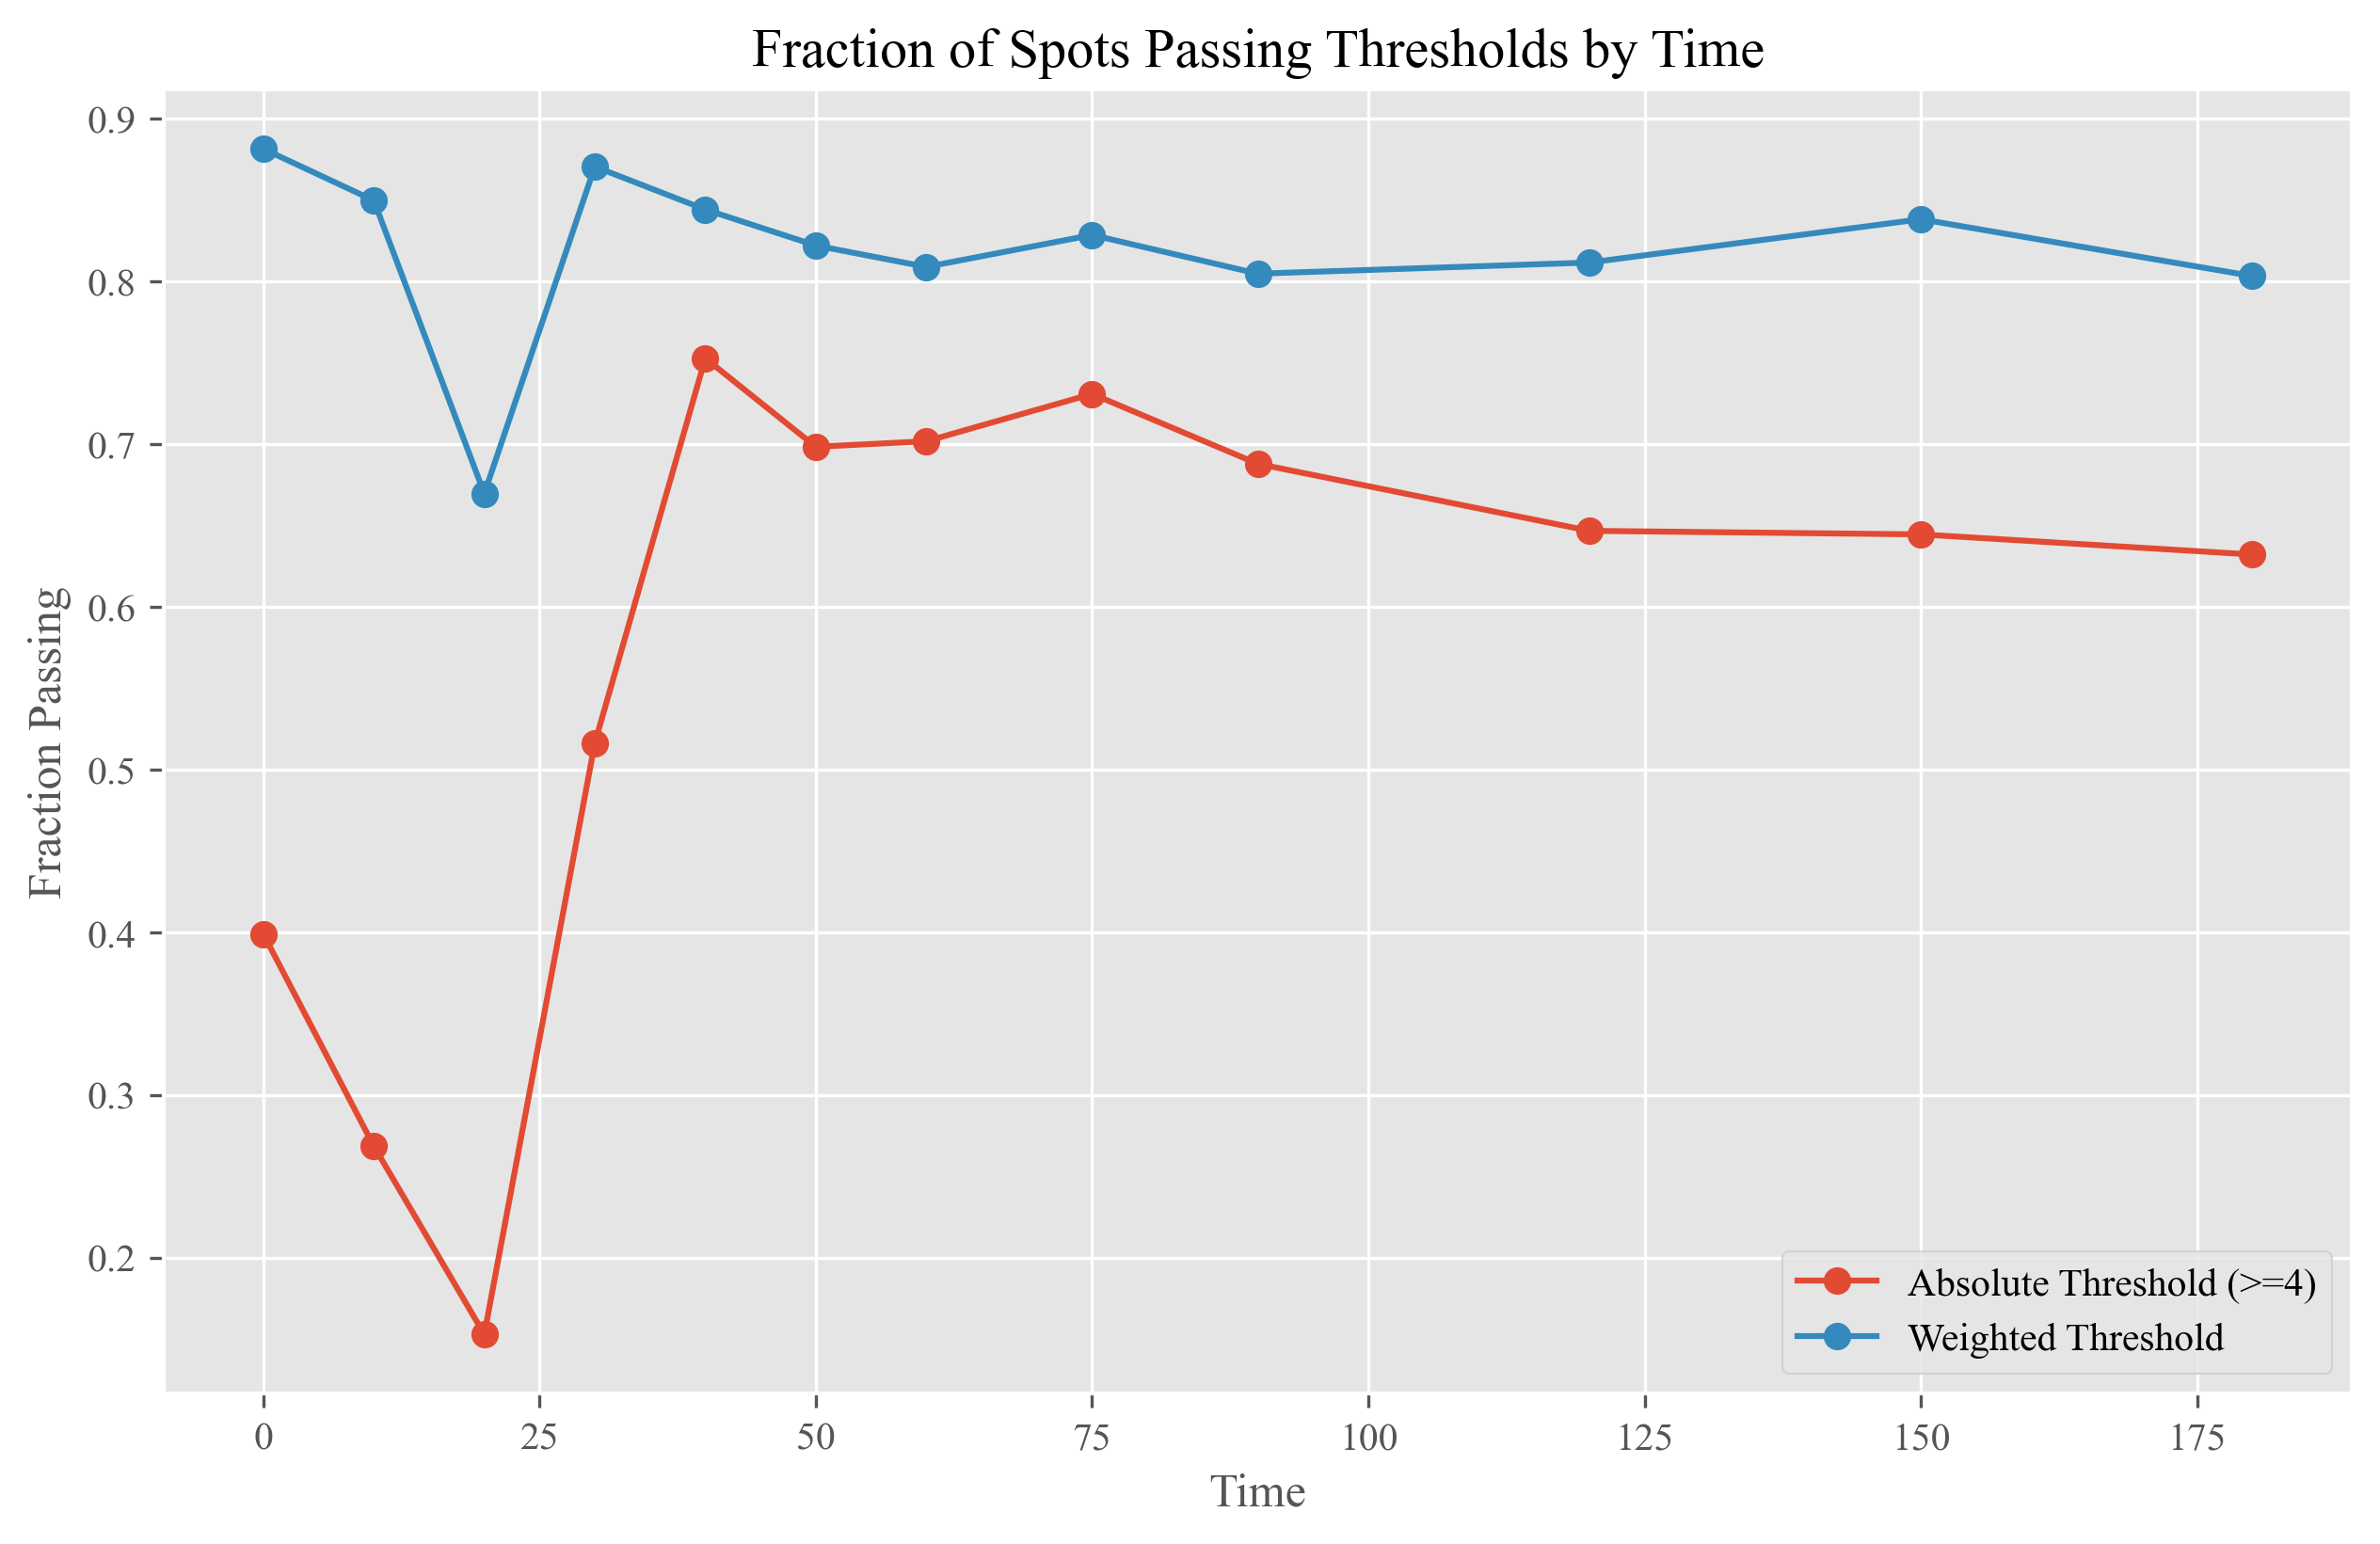

In [16]:
# Group by time_x and calculate the fraction passing each threshold.
time_groups = merged_spots_df.groupby('time')
abs_fraction = time_groups['absolute'].mean()  # True = 1, so the mean is the fraction passing.
weighted_fraction = time_groups['weighted'].mean()

plt.figure(figsize=(10, 6))
plt.plot(abs_fraction.index, abs_fraction, marker='o', label='Absolute Threshold (>=4)')
plt.plot(weighted_fraction.index, weighted_fraction, marker='o', label='Weighted Threshold')
plt.title('Fraction of Spots Passing Thresholds by Time')
plt.xlabel('Time')
plt.ylabel('Fraction Passing')
plt.legend()
plt.show()

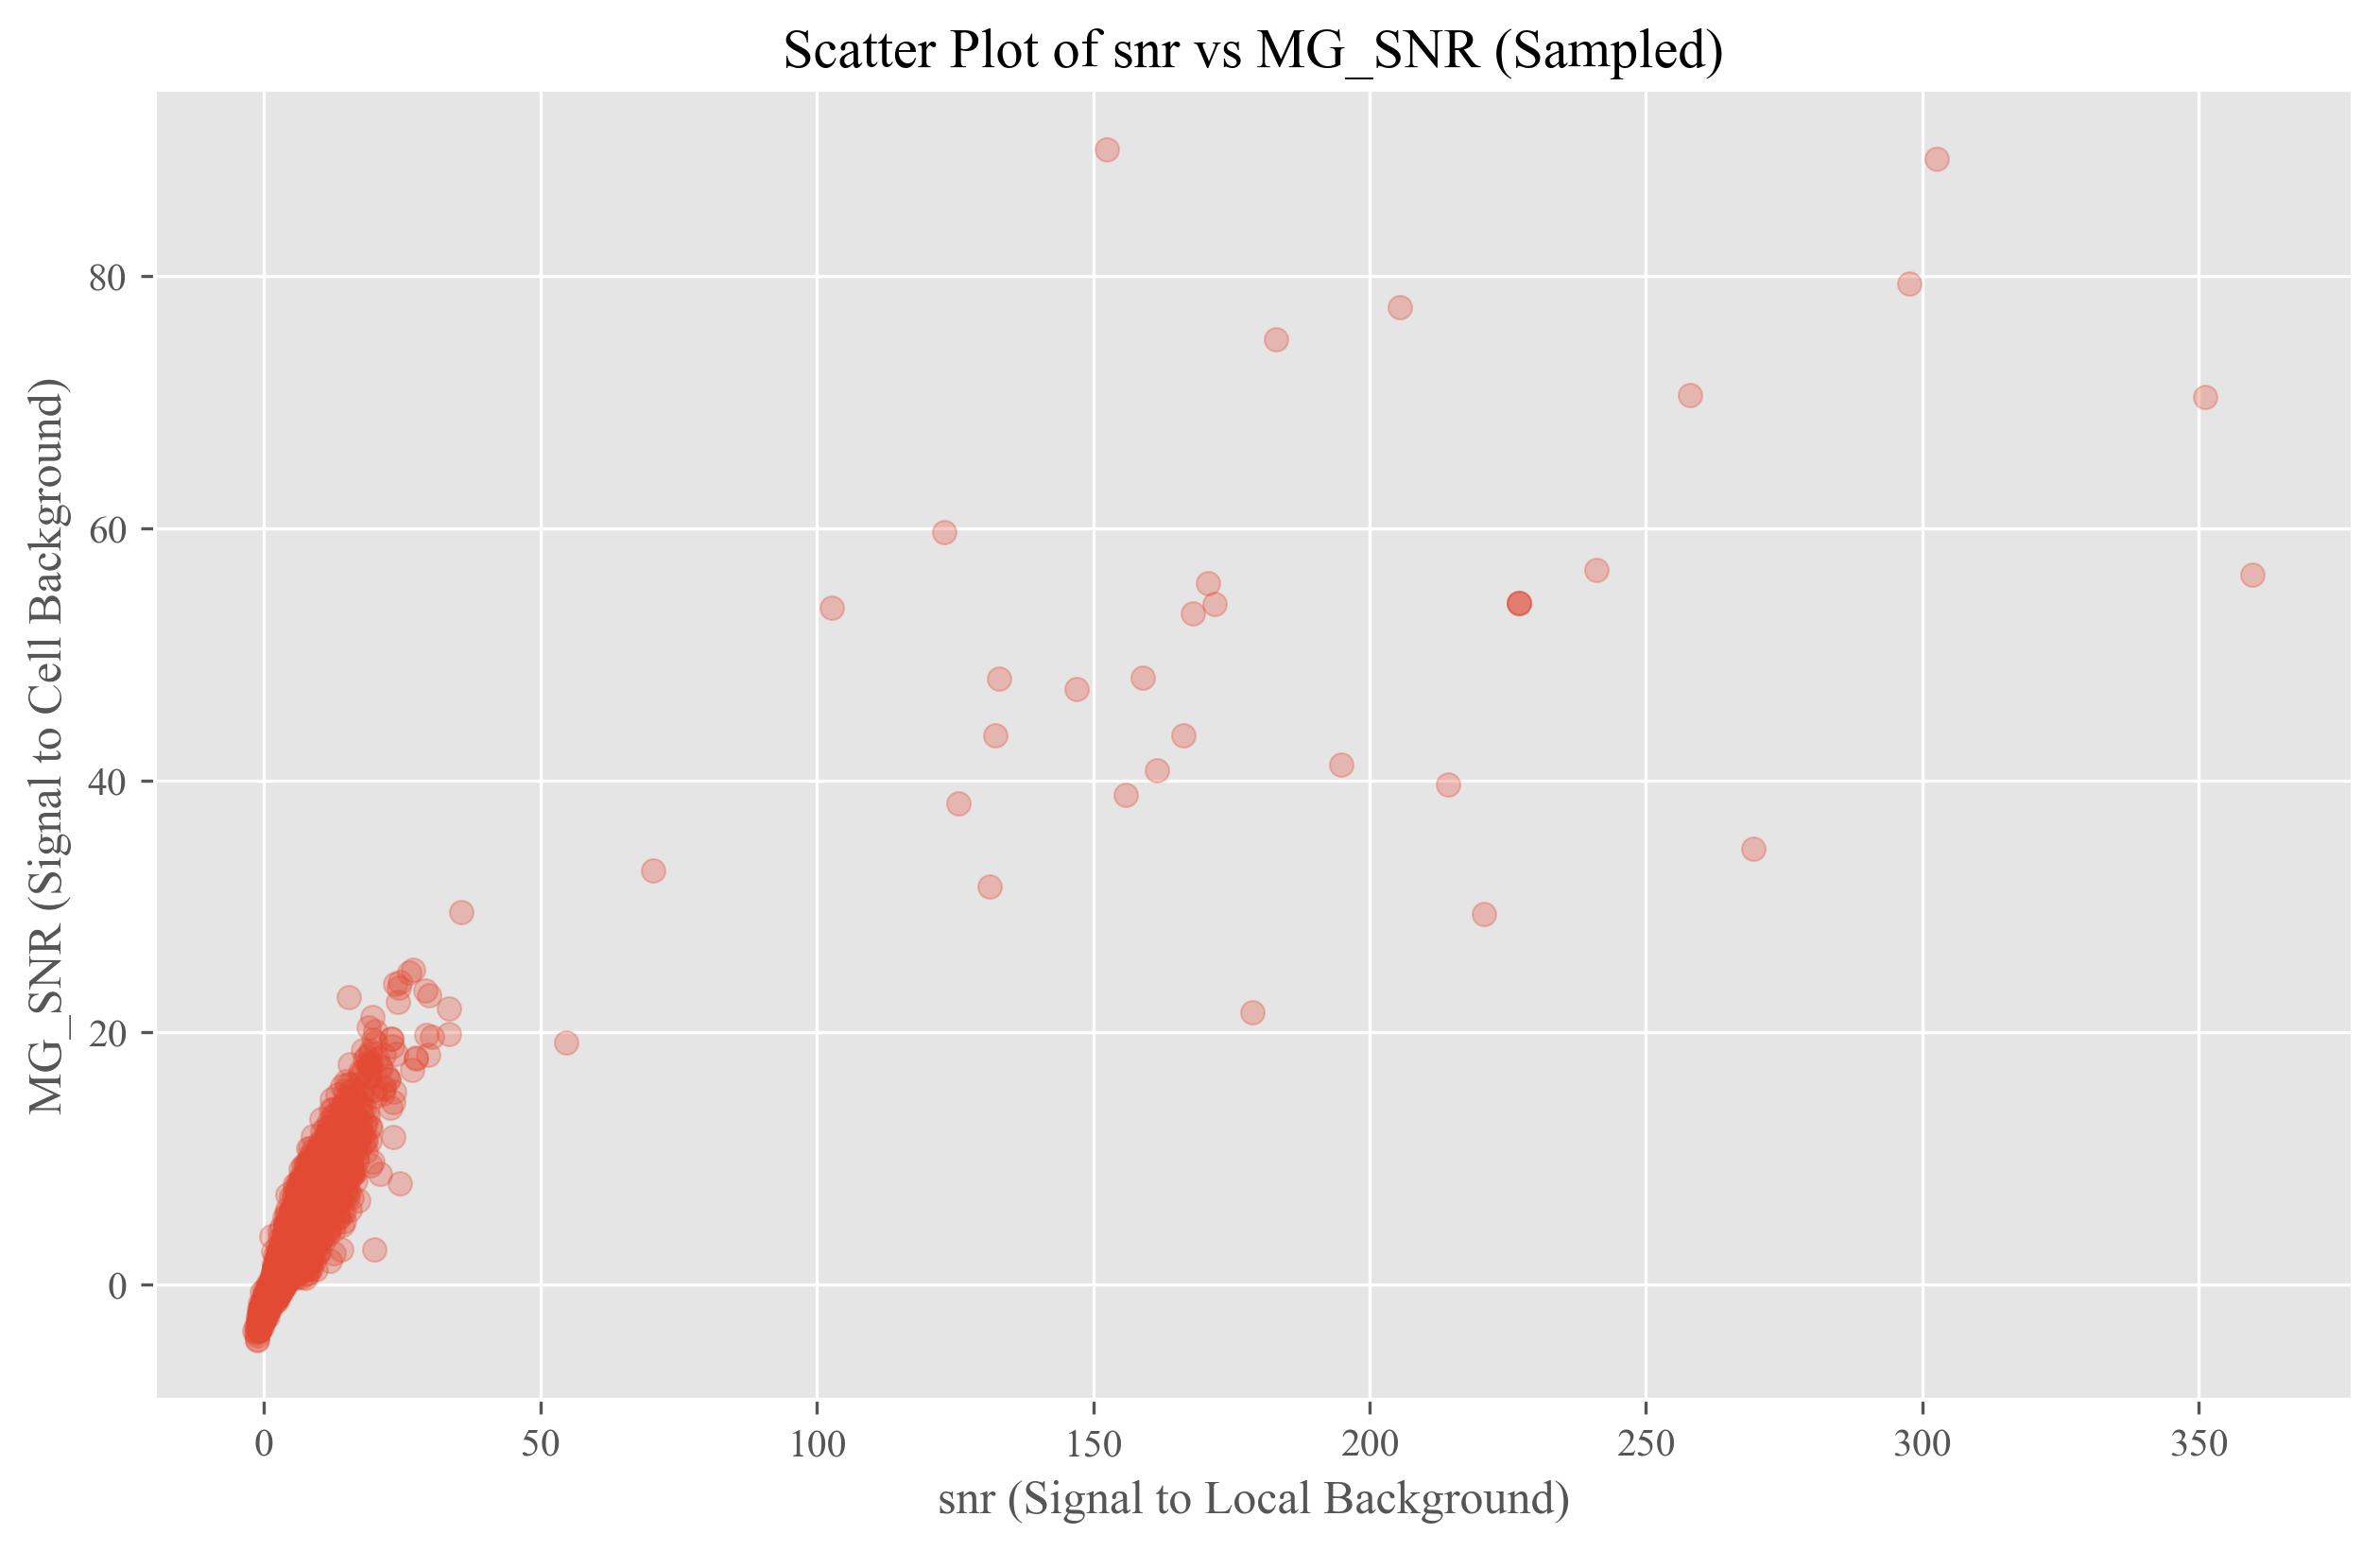

In [17]:
# Sample up to 1000 spots per time point for visualization.
sampled_df = merged_spots_df.groupby('time', group_keys=False).apply(lambda x: x.sample(min(1000, len(x))))

plt.figure(figsize=(10, 6))
plt.scatter(sampled_df['snr'], sampled_df['MG_SNR'], alpha=0.3)
plt.xlabel('snr (Signal to Local Background)')
plt.ylabel('MG_SNR (Signal to Cell Background)')
plt.title('Scatter Plot of snr vs MG_SNR (Sampled)')
plt.show()

In [18]:
# #TODO: check why there are missing cells in the spots dataframe

# # Compute the set of unique cell IDs in each DataFrame.
# cellprops_ids = set(merged_cellprops_df['unique_cell_id'].unique())
# spots_ids = set(merged_spots_df['unique_cell_id'].unique())

# # Determine the missing cell IDs (cells in cellprops but not in spots).
# missing_cell_ids = cellprops_ids - spots_ids
# print("Missing cell IDs:", missing_cell_ids)
# print("Number of missing cells:", len(missing_cell_ids))

# # Retrieve the rows from cellprops corresponding to these missing cell IDs.
# missing_cells_details = merged_cellprops_df[merged_cellprops_df['unique_cell_id'].isin(missing_cell_ids)]
# print("Missing cell details:")
# print(missing_cells_details)

In [19]:
merged_spots_df.keys()

Index(['z_px', 'y_px', 'x_px', 'cluster_index', 'is_nuc', 'cell_label',
       'nuc_label', 'snr', 'signal', 'timepoint', 'fov', 'FISH_Channel',
       'condition', 'replica', 'time', 'Dex_Conc', 'NAS_location', 'h5_idx',
       'unique_spot_id', 'unique_cell_id', 'cell_intensity_mean-0',
       'cell_intensity_std-0', 'nuc_intensity_mean-0', 'nuc_intensity_std-0',
       'cyto_intensity_mean-0', 'cyto_intensity_std-0', 'MG_SNR', 'weighted',
       'absolute', 'snr_vs_mg', 'mg_lt_snr'],
      dtype='object')

In [20]:
# Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen SNR threshold 
cell_level_results = dusp.measure(snr_threshold=4)

# Now cell_level_results is a cell-level dataframe that you can use for comparisons,
# downstream analysis, or plotting with your preferred tools.
print(cell_level_results.head())

   cell_id  weighted_count  nuc_weighted_count  cyto_weighted_count  \
0        0             433                 184                  249   
1        1             197                  49                  148   
2        2             268                  79                  189   
3        3             125                  47                   78   
4        4             241                  91                  150   

   absolute_count  nuc_absolute_count  cyto_absolute_count  MG_count  \
0             402                 165                  237       293   
1             177                  43                  134       155   
2             252                  76                  176       218   
3             108                  39                   69        93   
4             223                  88                  135       192   

   nuc_MG_count  cyto_MG_count  ...  avg_cyto_int  avg_cell_int  std_cell_int  \
0           110            183  ...    1424.75647   1451.12

In [21]:
cell_level_results.to_csv('TS_R1_cell_level_results_snr4_Mar20.csv')

(5439, 32)

In [ ]:
cell_level_results.keys()

In [ ]:
clusters_df.keys()

In [ ]:
spots_df.keys()

In [ ]:
# Create an instance of the display manager
display_manager = DUSP1DisplayManager(am, cell_level_results)

# Run the display routine; this will pop up figures inline.
display_manager.display(newFOV=True, newCell=True, spotChannel=0, cytoChannel=1, nucChannel=2)

In [ ]:
am.close()